## Classificação multilinguagem

In [1]:
import os
import gc
import pandas as pd
import numpy as np
import glob
import json

import librosa
import librosa.display
import IPython.display as ipd
import noisereduce as nr

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import shap

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

/Users/marcospaulo/Projects/multilingual_classification/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0. Carregamos o dataset

Importamos o dataset que geramos anteriormente, com aproximadamente 1 hora de áudio por idioma e balanceado por sexo

In [2]:
%%time
df_audios = pd.read_csv("../data/audios.csv", index_col=0)

CPU times: user 25.8 s, sys: 4.43 s, total: 30.2 s
Wall time: 46.2 s


In [3]:
df_audios.shape

(947, 11)

In [4]:
df_audios.head()

language                id  speaker  book  segment gender  \
0  italian  8828_8610_000510     8828  8610      510      F   
1  italian    659_547_000790      659   547      790      F   
2  italian    643_529_000116      643   529      116      F   
3  italian  8828_8610_000321     8828  8610      321      F   
4  italian    659_547_000279      659   547      279      F   

                                      title  \
0  Novelle per un Anno, vol. 12: Il Viaggio   
1                    Avventure di Pinocchio   
2                           Divina Commedia   
3  Novelle per un Anno, vol. 12: Il Viaggio   
4                    Avventure di Pinocchio   

                                               audio  length     sr  \
0  [0.0, 3.0517578125e-05, 3.0517578125e-05, 6.10...  318560  16000   
1  [0.0, 3.0517578125e-05, 0.0, 3.0517578125e-05,...  186880  16000   
2  [-0.007232666015625, -0.004913330078125, -0.00...  314560  16000   
3  [0.0, 3.0517578125e-05, 0.0, 0.0, 3.0517578125...  229920  16000   
4  [0.0, 0.0, 0.0, -3.0517578125e-05, -9.15527343...  197440  16000   

   duration_s  
0       19.91  
1       11.68  
2       19.66  
3       14.37  
4       12.34

In [5]:
%%time
df_audios["audio"] = df_audios.apply(lambda x : np.array(json.loads(x["audio"])), axis=1)

CPU times: user 24.9 s, sys: 2.89 s, total: 27.8 s
Wall time: 39 s


In [6]:
df_audios.dtypes

language       object
id             object
speaker         int64
book            int64
segment         int64
gender         object
title          object
audio          object
length          int64
sr              int64
duration_s    float64
dtype: object

In [7]:
type(df_audios.iloc[0]["audio"])

numpy.ndarray

#### Características do sinal e da FFT

In [8]:
sr = 16000 # pegamos do README.md

Vamos fazer os tratamentos do sinal para os tamanhos de janela de 50 ms, 100 ms, 200 ms

In [9]:
win_sizes = [0.050, 0.100, 0.200]

In [10]:
win_lengths = [int(sr * win_size) for win_size in win_sizes]
win_lengths

[800, 1600, 3200]

In [11]:
hop_lengths = [int(win_length // 2) for win_length in win_lengths] # sobreposição de 50%
hop_lengths

[400, 800, 1600]

In [12]:
n_ffts = [int(win_length * 2) for win_length in win_lengths]
n_ffts

[1600, 3200, 6400]

$n\_fft = 2 * win\_length = 4 * hop\_length$

#### Visualização de um áudio em cada idioma

In [13]:
df_audios["language"].unique()

array(['italian', 'polish', 'portuguese', 'spanish'], dtype=object)

In [14]:
# Italiano
x_ita = df_audios[df_audios["language"] == "italian"].iloc[0]["audio"]
ipd.Audio(x_ita, rate=sr)

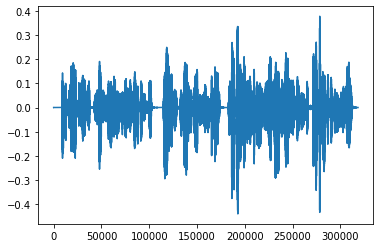

In [15]:
plt.plot(x_ita)

In [16]:
# Polonês
x_pol = df_audios[df_audios["language"] == "polish"].iloc[0]["audio"]
ipd.Audio(x_pol, rate=sr)

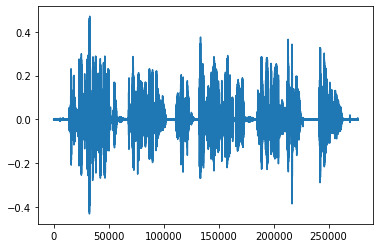

In [17]:
plt.plot(x_pol)

In [18]:
# Português
x_por = df_audios[df_audios["language"] == "portuguese"].iloc[0]["audio"]
ipd.Audio(x_por, rate=sr)

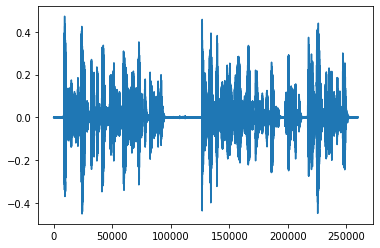

In [19]:
plt.plot(x_por)

In [20]:
# Espanhol
x_esp = df_audios[df_audios["language"] == "spanish"].iloc[0]["audio"]
ipd.Audio(x_esp, rate=sr)

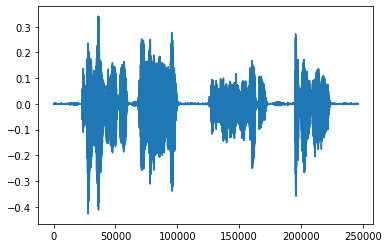

In [21]:
plt.plot(x_esp)

In [22]:
n_ffts[0], win_lengths[0], hop_lengths[0]

(1600, 800, 400)

### 1.  Preparação dos áudios

Antes da etapa de feature engineering, precisamos fazer alguns ajustes nos áudios:
* Remoção de ruído
* Remoção de silêncio
    - Cálculo da feature de tempo de silêncio total
* Filtro de pré-ênfase

#### 1.1 Remoção de ruído

Vamos aplicar remoção de ruído para tornar o sinal mais nítido e retirar barulhos de fundo dos áudios. É utilizada uma técnica chamada "spectral gating", que é uma forma de _Noise Gate._ Em [1] está explicado o funcionamento da técnica:

"Noisereduce is a noise reduction algorithm in python that reduces noise in time-domain signals like speech, bioacoustics, and physiological signals. It relies on a method called "spectral gating" which is a form of Noise Gate. It works by computing a spectrogram of a signal (and optionally a noise signal) and estimating a noise threshold (or gate) for each frequency band of that signal/noise. That threshold is used to compute a mask, which gates noise below the frequency-varying threshold.

The most recent version of noisereduce comprises two algorithms:

- Stationary Noise Reduction: Keeps the estimated noise threshold at the same level across the whole signal
- Non-stationary Noise Reduction: Continuously updates the estimated noise threshold over time" (https://pypi.org/project/noisereduce/)

Vamos aplicar ao sinal em português e ver a diferença

In [23]:
ipd.Audio(x_por, rate=sr)

In [24]:
x_por_reduced = nr.reduce_noise(
    y=x_por,
    sr=sr,
    stationary=False,
    prop_decrease=0.9, # Vou tirar 90% do ruído
    n_fft=n_ffts[0],
    win_length=win_lengths[0],
    hop_length=hop_lengths[0],
    n_jobs=-1
)

In [25]:
# Português
ipd.Audio(x_por_reduced, rate=sr)

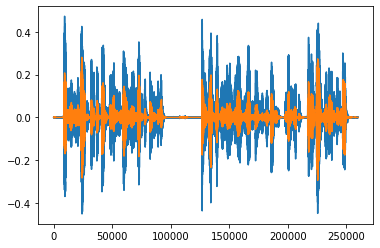

In [26]:
plt.plot(x_por)
plt.plot(x_por_reduced)

Percebemos que o som fica mais limpo após a aplicação da remoção de ruído de fundo.

Função:

In [27]:
def apply_noise_reduction(x, sr, n_fft, win_length, hop_length):
    x_reduced = nr.reduce_noise(
        y=x,
        sr=sr,
        stationary=False, # Non-stationary Noise Reduction: Continuously updates the estimated noise threshold over time
        prop_decrease=0.9, # Vou tirar 90% do ruído
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_jobs=-1
    )
    return x_reduced

In [28]:
apply_noise_reduction(x_por, sr, n_fft=n_ffts[0], win_length=win_lengths[0], hop_length=hop_lengths[0])

array([-2.44140625e-05,  3.05175781e-06,  2.74658203e-05, ...,
        2.74658166e-05,  1.83105435e-05,  6.10351262e-06])

#### 1.2 Remoção de silêncio

Vamos remover trechos de silêncio do áudio, e computar o total de tempo de silêncio que foi removido. Os trechos de silêncio não trazem uma contribuição significativa para a construção das features de áudio como MFCCs, por exemplo. Portanto, vamos removê-los.

Vamos aplicar ao sinal em português e ver a diferença

##### 1.2.1 Função trim()

Removemos silêncio nos extremos do sinal

In [29]:
ipd.Audio(x_por_reduced, rate=sr)

In [30]:
x_por_trimmed, index = librosa.effects.trim(
    x_por_reduced,
    top_db=50,
    frame_length=n_ffts[0],
    hop_length=hop_lengths[0]
)

In [31]:
index # non-silent region

array([  8000, 252000])

In [32]:
ipd.Audio(x_por_trimmed, rate=sr)

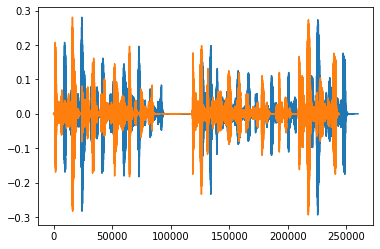

In [33]:
plt.plot(x_por_reduced)
plt.plot(x_por_trimmed)

##### 1.2.2 Função split()

Removemos silêncios dentro do sinal

In [34]:
ipd.Audio(x_por_trimmed, rate=sr)

In [35]:
n_ffts[0], hop_lengths[0]

(1600, 400)

In [36]:
intervals = librosa.effects.split(
    x_por_trimmed,
    top_db=50,
    frame_length=n_ffts[0],
    hop_length=hop_lengths[0]
)

In [37]:
intervals

array([[     0,  87200],
       [118000, 185600],
       [189200, 204000],
       [208400, 244000]])

In [38]:
x_por_splitted = []
for interval in intervals:
    x_por_splitted = np.hstack([x_por_splitted, x_por_trimmed[interval[0]:interval[1]]])

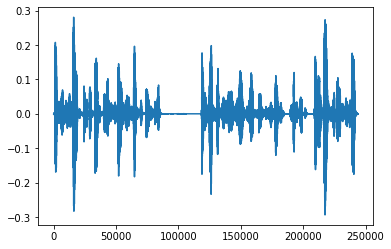

In [39]:
plt.plot(x_por_trimmed)

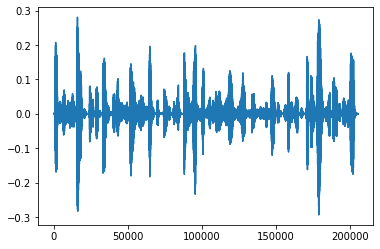

In [40]:
plt.plot(x_por_splitted)

In [41]:
ipd.Audio(x_por_splitted, rate=sr)

#### 1.2.3 Cálculo do tempo total de silêncio

Para calcular esta feature, basta calcular quanto tempo corresponde aos trechos de silêncio removidos do sinal.

In [42]:
index

array([  8000, 252000])

In [43]:
intervals

array([[     0,  87200],
       [118000, 185600],
       [189200, 204000],
       [208400, 244000]])

In [44]:
non_silent_samples = \
    sum([(interval[1] - interval[0]) for interval in intervals]) # splitted

In [45]:
non_silent_samples

205200

In [46]:
silent_samples = len(x_por) - non_silent_samples

In [47]:
silent_samples

54800

In [48]:
total_silent_time = silent_samples / sr

In [49]:
total_silent_time # in seconds

3.425

Funções:

In [50]:
def apply_trim(x, sr, win_length, hop_length, top_db=50):
    x_trimmed, index = librosa.effects.trim(
        x,
        top_db=top_db,
        frame_length=win_length,
        hop_length=hop_length
    )
    return x_trimmed, index

def apply_split(x, sr, win_length, hop_length, top_db=50):
    intervals = librosa.effects.split(
        x,
        top_db=top_db,
        frame_length=win_length,
        hop_length=hop_length
    )
    
    x_splitted = []
    for interval in intervals:
        x_splitted = np.hstack([x_splitted, x[interval[0]:interval[1]]])
        
    return x_splitted, intervals

def apply_silence_remotion(x, sr, win_length, hop_length, top_db=50):
    x_trimmed, index_non_silent = apply_trim(x, sr, win_length, hop_length, top_db=50)
    x_non_silent, intervals_non_silent = apply_split(x_trimmed, sr, win_length, hop_length, top_db=50)
    return x_non_silent, index_non_silent, intervals_non_silent

def get_total_silence_time(intervals_non_silent):
    non_silent_samples = \
        sum([(interval[1] - interval[0]) for interval in intervals_non_silent]) # splitted
    silent_samples = len(x_por) - non_silent_samples
    total_silent_time = silent_samples / sr
    return total_silent_time # in seconds

In [51]:
apply_trim(x_por_reduced, sr, win_length=win_lengths[0], hop_length=hop_lengths[0], top_db=50)

(array([-2.98109307e-04,  2.23226908e-05,  1.85271734e-05, ...,
         8.06589424e-05,  8.78712592e-05,  1.19459937e-04]),
 array([  8000, 252000]))

In [52]:
apply_split(x_por_trimmed, sr, win_length=win_lengths[0], hop_length=hop_lengths[0], top_db=50)

(array([-2.98109307e-04,  2.23226908e-05,  1.85271734e-05, ...,
         8.06589424e-05,  8.78712592e-05,  1.19459937e-04]),
 array([[     0,  23200],
        [ 23600,  86800],
        [118400, 185600],
        [189600, 203600],
        [208800, 244000]]))

In [53]:
apply_silence_remotion(x_por_reduced, sr, win_length=win_lengths[0], hop_length=hop_lengths[0], top_db=50)

(array([-2.98109307e-04,  2.23226908e-05,  1.85271734e-05, ...,
         8.06589424e-05,  8.78712592e-05,  1.19459937e-04]),
 array([  8000, 252000]),
 array([[     0,  23200],
        [ 23600,  86800],
        [118400, 185600],
        [189600, 203600],
        [208800, 244000]]))

In [54]:
get_total_silence_time(intervals)

3.425

#### 1.3 Filtro de pré-ênfase

Aplicamos um filtro de pré-ênfase ao sinal de voz para amplificar as frequências altas e atenuar as frequências baixas. Fazemos isso, pois os sinais de voz apresentam mais energia nas frequências mais baixas em relação às baixas, e gostaríamos de compensar esse efeito.

O filtro de pré-ênfase tem este formato:

$ H(z) = 1 − a z^{−1} $, com $a = 0.97$ ou $a = 0.98$. Vou adotar $a = 0.97$.

In [55]:
ipd.Audio(x_por_splitted, rate=sr)

In [56]:
PRE_EMPHASIS_COEFFICIENT = 0.97
x_transformed = librosa.effects.preemphasis(x_por_splitted, coef=PRE_EMPHASIS_COEFFICIENT)

In [57]:
ipd.Audio(x_transformed, rate=sr)

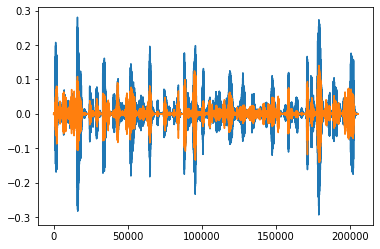

In [58]:
plt.plot(x_por_splitted)
plt.plot(x_transformed)

### 2. Feature engineering

Agora vamos construir algumas features que parecem relevantes para conseguir diferenciar os áudios em relação ao idioma falado:

- Estimação da F0 em cada segmento, delta médio entre segmentos consecutivos (Jitter): frequência (dinâmica da F0 => entonação) (https://librosa.org/doc/main/generated/librosa.pyin.html)
- 13 MFCCs, ∆ and ∆-∆: pitch (percepção da frequência; dinâmica das variações de frequência percebida) (Aula 5 - MFCC_Basics => https://librosa.org/doc/main/generated/librosa.feature.mfcc.html)
- RMS, ∆ and ∆-∆ (log?), Shimmer: energia (variações de energia no sinal de voz => tonicidade / stress) (https://librosa.org/doc/main/generated/librosa.feature.rms.html)
- zero-crossing (total) => intervalos não vozeados, porcentagem do tempo em que zero-cross > 30% (não vozeados), desvio padrão dos tempos dos intervalos não vozeados: ritmo / duração (https://linguistica.fflch.usp.br/sites/linguistica.fflch.usp.br/files/inline-files/The%20Rhythm%20Class%20Hypothesis%20and%20indigenous%20languages.pdf).

Descrições:

- Jitter and shimmer voice-quality measurements measure variations of the fundamental frequency and the amplitude of speaker’s voice, respectively. They have been applied in several speaker-related tasks reporting successful results. For instance, it is reported in [8] that adding jitter and shimmer voice-quality features to the baseline spectral ones improves the performance of a speaker recognition system. By using Praat [33], five different jitter and six different shimmer measurement estimations can be extracted. (https://asmp-eurasipjournals.springeropen.com/track/pdf/10.1186/s13636-018-0140-x.pdf)

<img src="./jitter_shimmer.png" width=250, height=250 />

- Pitch: Pitch is the most important prosodic property of speech. It contains speaker-specific information. The default pitch value and range of a speaker is influenced by the length and mass of the vocal folds in the larynx [35]. The pitch values of different speakers vary in relation to their age and gender. Pitch can be used as an important acoustic cue for tone, lexical stress, and intonation.
(https://librosa.org/doc/main/generated/librosa.pyin.html: calcular f0 de cada segmento e então calcular a média e o desvio padrão)
(https://asmp-eurasipjournals.springeropen.com/track/pdf/10.1186/s13636-018-0140-x.pdf)

- Acoustic intensity: It shows changes in loudness or energy (RMS) of a speech signal. It is used to mark stress and express emotions. Therefore, changes in loudness can be used as a potential speaker discriminant measure.

- Formant frequencies: They are concentrations of acoustic energy around particular frequencies at roughly 1000-Hz intervals. They occur only in voiced speech segments around frequencies that correspond to the speaker-specific resonances of the vocal tract. Therefore, they are suitable measures to help discriminate speakers.

- % vocálicos e desvio padrão

<img src="./proporcao_vocalicos.png" width=250, height=250 />

(https://linguistica.fflch.usp.br/sites/linguistica.fflch.usp.br/files/inline-files/The%20Rhythm%20Class%20Hypothesis%20and%20indigenous%20languages.pdf)

- spectral rollof (https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html), flux, spectral flatness per band
(https://link.springer.com/content/pdf/10.1007/s11042-016-4315-0.pdf)

In [59]:
x_transformed

array([-9.16650613e-04,  3.11488719e-04, -3.12583668e-06, ...,
        9.46197906e-06,  9.63208505e-06,  3.42248159e-05])

In [60]:
ipd.Audio(x_transformed, rate=sr)

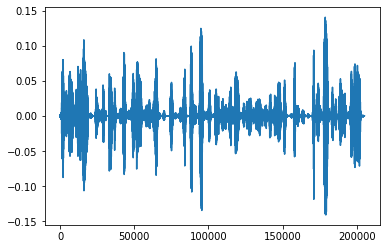

In [61]:
plt.plot(x_transformed)

#### 2.1 Estimação da F0
- F0 em cada segmento
- Jitter (delta médio entre segmentos consecutivos)

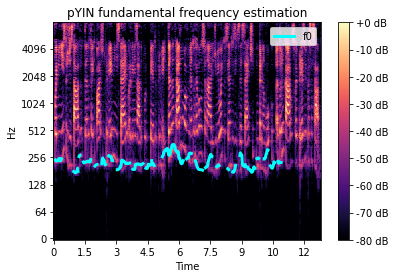

In [62]:
f0, voiced_flag, voiced_probs = librosa.pyin(
    y=x_transformed,
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7'),
    sr=sr,
    frame_length=n_ffts[0],
    win_length=win_lengths[0],
    hop_length=hop_lengths[0]
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(x_transformed)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

In [63]:
len(f0)

514

In [67]:
def get_features_from_f0(f0, order=None):
    df_f0 = pd.DataFrame(data=f0, columns=["f0"])
    
    f0_mean = np.nanmean(df_f0["f0"])
    f0_std = np.nanstd(df_f0["f0"])
    
    df_f0["diff_f0"] = df_f0["f0"].diff()
    diff_f0_mean = np.nanmean(df_f0["diff_f0"])
    diff_f0_std = np.nanstd(df_f0["diff_f0"])
    df_f0["T"] = 1 / df_f0["f0"]
    df_f0["diff_T"] = df_f0["T"].diff(-1) # passado menos futuro
    df_f0["abs_diff_T"] = df_f0["T"].abs()
    jitter = np.nansum(df_f0["abs_diff_T"]) / (np.sum(df_f0["abs_diff_T"].notna()) - 1)
    
    f0 = np.nan_to_num(f0) # nan -> zero
    
    data = [[json.dumps(list(f0)), f0_mean, f0_std, jitter]]
    if order == None:
        columns = ["f0", "f0_mean", "f0_std", "jitter"]
    else:
        columns = ["f0_delta_{}".format(order), "f0_delta_{}_mean".format(order), "f0_delta_{}_std".format(order), "jitter_delta_{}".format(order)]
    
    df_f0_features = pd.DataFrame(data=data, columns=columns)
    return df_f0_features

In [68]:
f0_, voiced_flag_, voiced_probs_ = librosa.pyin(
    y=x_transformed,
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7'),
    sr=sr,
    frame_length=n_ffts[0],
    win_length=win_lengths[0],
    hop_length=hop_lengths[0]
)

In [69]:
f0_features = get_features_from_f0(f0_)
f0_features

f0     f0_mean     f0_std  \
0  [0.0, 0.0, 0.0, 239.91170118635668, 235.790161...  231.396752  40.360206   

     jitter  
0  0.004458

In [70]:
f0_delta_1 = librosa.feature.delta(f0_, order=1)
get_features_from_f0(f0_delta_1, order=1)

f0_delta_1  f0_delta_1_mean  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.30656474...        -0.234506   

   f0_delta_1_std  jitter_delta_1  
0         5.61189    5.939826e+12

In [71]:
f0_delta_2 = librosa.feature.delta(f0_, order=2)
get_features_from_f0(f0_delta_2, order=2)

f0_delta_2  f0_delta_2_mean  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.31159810...        -0.121051   

   f0_delta_2_std  jitter_delta_2  
0        1.827791        2.121035

Estimativa de f1 e f2 (formantes) - por autocorrelação

In [72]:
#len(x_transformed)

In [73]:
#voiced_flag

In [74]:
#autocorr = librosa.autocorrelate(x_transformed)

In [75]:
#plt.plot(autocorr)

- Intervalos não vozeados
    - Desvio padrão dos tempos dos intervalos não vozeados

In [76]:
df_voiced = pd.DataFrame(data=voiced_flag, columns=["voiced"])
df_voiced.value_counts()

voiced
True      282
False     232
dtype: int64

In [77]:
df_voiced

voiced
0     False
1     False
2     False
3      True
4      True
..      ...
509   False
510   False
511   False
512   False
513   False

[514 rows x 1 columns]

In [78]:
def get_non_voiced_features(x, sr, voiced_flag, hop_length=512):
    df_voiced = pd.DataFrame(data=voiced_flag, columns=["voiced"])
    df_non_voiced = df_voiced[df_voiced["voiced"] == False]
    
    length_non_voiced = len(df_non_voiced) * hop_length / 2
    non_voiced_pct = length_non_voiced / len(x)
    
    df_non_voiced = df_non_voiced.reset_index()
    df_non_voiced["diff"] = df_non_voiced["index"].diff() # qtde. frames
    df_non_voiced = df_non_voiced[df_non_voiced["diff"] > 1]
    df_non_voiced["non_voiced_length"] = df_non_voiced["diff"] * hop_length / 2 # qtde. amostras
    df_non_voiced["non_voiced_total_time"] = df_non_voiced["non_voiced_length"] / sr # qtde. tempo
    
    non_voiced_mean = df_non_voiced["non_voiced_total_time"].mean()
    non_voiced_std = df_non_voiced["non_voiced_total_time"].std()
    
    data = [[non_voiced_pct, non_voiced_mean, non_voiced_std]]
    columns = ["non_voiced_pct", "non_voiced_time_mean", "non_voiced_time_std"]
    
    df_non_voiced_features = pd.DataFrame(data=data, columns=columns)
    
    return df_non_voiced_features

In [79]:
get_non_voiced_features(x_transformed, sr, voiced_flag, hop_length=hop_lengths[0])

non_voiced_pct  non_voiced_time_mean  non_voiced_time_std
0        0.226121              0.134052             0.062401

#### 2.2 MFCCs
- 13 MFCCs
- ∆MFCCs
- ∆-∆MFCCs

In [80]:
n_mfcc = 13

In [81]:
def get_mean_std_from_mfcc(mfcc, order=None):
    df_mfcc = pd.DataFrame(data=mfcc)
    df_mfcc["mean"] = df_mfcc.mean(axis=1)
    df_mfcc["std"] = df_mfcc.std(axis=1)
    
    df_aux = df_mfcc[["mean", "std"]].copy()
    df_aux = df_aux.T
    
    if order == None:
        df_mean = df_aux.loc["mean"].to_frame().T.reset_index(drop=True)
        df_mean.columns = ["mfcc_{}_mean".format(str(col).zfill(2)) for col in df_mean.columns]
        df_std = df_aux.loc["std"].to_frame().T.reset_index(drop=True)
        df_std.columns = ["mfcc_{}_std".format(str(col).zfill(2)) for col in df_std.columns]
    else:
        df_mean = df_aux.loc["mean"].to_frame().T.reset_index(drop=True)
        df_mean.columns = ["mfcc_{}_delta_{}_mean".format(str(col).zfill(2), order) for col in df_mean.columns]
        df_std = df_aux.loc["std"].to_frame().T.reset_index(drop=True)
        df_std.columns = ["mfcc_{}_delta_{}_std".format(str(col).zfill(2), order) for col in df_std.columns]
    
    df_features = pd.concat([df_mean, df_std], axis=1)
    df_features.columns = sorted(df_features.columns)
    return df_features

MFCC

In [82]:
mfcc = librosa.feature.mfcc(
    y=x_transformed,
    sr=sr,
    win_length=win_lengths[0],
    n_fft=n_ffts[0],
    hop_length=hop_lengths[0],
    window='hamming',
    n_mfcc=n_mfcc
)

In [83]:
mfcc_feats = get_mean_std_from_mfcc(mfcc, order=None)

In [84]:
mfcc_feats

mfcc_00_mean  mfcc_00_std  mfcc_01_mean  mfcc_01_std  mfcc_02_mean  \
0   -570.757946    11.818874     -6.001032     2.026905    -44.258126   

   mfcc_02_std  mfcc_03_mean  mfcc_03_std  mfcc_04_mean  mfcc_04_std  \
0   -15.908529    -20.586292   -21.881348     -5.386069   -16.172161   

   mfcc_05_mean  mfcc_05_std  mfcc_06_mean  mfcc_06_std  mfcc_07_mean  \
0      3.013572   -18.273668     10.806366   110.445284     59.784337   

   mfcc_07_std  mfcc_08_mean  mfcc_08_std  mfcc_09_mean  mfcc_09_std  \
0    58.290935     41.860589    30.051941     22.361433    17.906494   

   mfcc_10_mean  mfcc_10_std  mfcc_11_mean  mfcc_11_std  mfcc_12_mean  \
0     16.466188    19.263775     14.648248    16.575592     14.926348   

   mfcc_12_std  
0    13.598433

Deltas (order = 1)

In [85]:
mfcc_delta_1 = librosa.feature.delta(mfcc)

In [86]:
mfcc_delta_1_feats = get_mean_std_from_mfcc(mfcc_delta_1, order=1)

In [87]:
mfcc_delta_1_feats

mfcc_00_delta_1_mean  mfcc_00_delta_1_std  mfcc_01_delta_1_mean  \
0             -0.628605             0.036042              0.106739   

   mfcc_01_delta_1_std  mfcc_02_delta_1_mean  mfcc_02_delta_1_std  \
0             0.138772              0.052097            -0.010583   

   mfcc_03_delta_1_mean  mfcc_03_delta_1_std  mfcc_04_delta_1_mean  \
0             -0.043433             0.054318             -0.040724   

   mfcc_04_delta_1_std  mfcc_05_delta_1_mean  mfcc_05_delta_1_std  \
0             0.045839             -0.063828             0.051939   

   mfcc_06_delta_1_mean  mfcc_06_delta_1_std  mfcc_07_delta_1_mean  \
0             -0.070536            23.359552             11.805449   

   mfcc_07_delta_1_std  mfcc_08_delta_1_mean  mfcc_08_delta_1_std  \
0            12.177511              7.395931              5.95488   

   mfcc_09_delta_1_mean  mfcc_09_delta_1_std  mfcc_10_delta_1_mean  \
0                 4.158               3.3556               3.00314   

   mfcc_10_delta_1_std  mfcc_11_delta_1_mean  mfcc_11_delta_1_std  \
0             3.746334              2.787648             3.231928   

   mfcc_12_delta_1_mean  mfcc_12_delta_1_std  
0              3.091107             2.331725

Deltas (order = 2)

In [88]:
mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)

In [89]:
mfcc_delta_2_feats = get_mean_std_from_mfcc(mfcc_delta_2, order=2)

In [90]:
mfcc_delta_2_feats

mfcc_00_delta_2_mean  mfcc_00_delta_2_std  mfcc_01_delta_2_mean  \
0             -0.397864            -0.145341              0.045482   

   mfcc_01_delta_2_std  mfcc_02_delta_2_mean  mfcc_02_delta_2_std  \
0            -0.024843              0.050266             0.025416   

   mfcc_03_delta_2_mean  mfcc_03_delta_2_std  mfcc_04_delta_2_mean  \
0              0.056177             0.038065              0.010475   

   mfcc_04_delta_2_std  mfcc_05_delta_2_mean  mfcc_05_delta_2_std  \
0             0.030151             -0.015901             0.041081   

   mfcc_06_delta_2_mean  mfcc_06_delta_2_std  mfcc_07_delta_2_mean  \
0             -0.010788            14.559313               6.74438   

   mfcc_07_delta_2_std  mfcc_08_delta_2_mean  mfcc_08_delta_2_std  \
0             6.215761               3.98896             4.151934   

   mfcc_09_delta_2_mean  mfcc_09_delta_2_std  mfcc_10_delta_2_mean  \
0               2.59027              2.01545              1.865251   

   mfcc_10_delta_2_std  mfcc_11_delta_2_mean  mfcc_11_delta_2_std  \
0             2.338932              1.593565             1.948137   

   mfcc_12_delta_2_mean  mfcc_12_delta_2_std  
0              1.813216             1.454487

In [ ]:
plt.figure(figsize=(18, 8))
plt.imshow(df_mfcc_t.T, origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f');
plt.ylabel('MFCC Coefficient Index')
plt.xlabel('Frame Index')
plt.title('')

Compilamos as features

In [91]:
mfcc_features = pd.concat([mfcc_feats, mfcc_delta_1_feats, mfcc_delta_2_feats], axis=1)
mfcc_features.columns = sorted(mfcc_features.columns)

In [92]:
mfcc_features

mfcc_00_delta_1_mean  mfcc_00_delta_1_std  mfcc_00_delta_2_mean  \
0           -570.757946            11.818874             -6.001032   

   mfcc_00_delta_2_std  mfcc_00_mean  mfcc_00_std  mfcc_01_delta_1_mean  \
0             2.026905    -44.258126   -15.908529            -20.586292   

   mfcc_01_delta_1_std  mfcc_01_delta_2_mean  mfcc_01_delta_2_std  \
0           -21.881348             -5.386069           -16.172161   

   mfcc_01_mean  mfcc_01_std  mfcc_02_delta_1_mean  mfcc_02_delta_1_std  \
0      3.013572   -18.273668             10.806366           110.445284   

   mfcc_02_delta_2_mean  mfcc_02_delta_2_std  mfcc_02_mean  mfcc_02_std  \
0             59.784337            58.290935     41.860589    30.051941   

   mfcc_03_delta_1_mean  mfcc_03_delta_1_std  mfcc_03_delta_2_mean  \
0             22.361433            17.906494             16.466188   

   mfcc_03_delta_2_std  mfcc_03_mean  mfcc_03_std  mfcc_04_delta_1_mean  \
0            19.263775     14.648248    16.575592             14.926348   

   mfcc_04_delta_1_std  mfcc_04_delta_2_mean  mfcc_04_delta_2_std  \
0            13.598433             -0.628605             0.036042   

   mfcc_04_mean  mfcc_04_std  mfcc_05_delta_1_mean  mfcc_05_delta_1_std  \
0      0.106739     0.138772              0.052097            -0.010583   

   mfcc_05_delta_2_mean  mfcc_05_delta_2_std  mfcc_05_mean  mfcc_05_std  \
0             -0.043433             0.054318     -0.040724     0.045839   

   mfcc_06_delta_1_mean  mfcc_06_delta_1_std  mfcc_06_delta_2_mean  \
0             -0.063828             0.051939             -0.070536   

   mfcc_06_delta_2_std  mfcc_06_mean  mfcc_06_std  mfcc_07_delta_1_mean  \
0            23.359552     11.805449    12.177511              7.395931   

   mfcc_07_delta_1_std  mfcc_07_delta_2_mean  mfcc_07_delta_2_std  \
0              5.95488                 4.158               3.3556   

   mfcc_07_mean  mfcc_07_std  mfcc_08_delta_1_mean  mfcc_08_delta_1_std  \
0       3.00314     3.746334              2.787648             3.231928   

   mfcc_08_delta_2_mean  mfcc_08_delta_2_std  mfcc_08_mean  mfcc_08_std  \
0              3.091107             2.331725     -0.397864    -0.145341   

   mfcc_09_delta_1_mean  mfcc_09_delta_1_std  mfcc_09_delta_2_mean  \
0              0.045482            -0.024843              0.050266   

   mfcc_09_delta_2_std  mfcc_09_mean  mfcc_09_std  mfcc_10_delta_1_mean  \
0             0.025416      0.056177     0.038065              0.010475   

   mfcc_10_delta_1_std  mfcc_10_delta_2_mean  mfcc_10_delta_2_std  \
0             0.030151             -0.015901             0.041081   

   mfcc_10_mean  mfcc_10_std  mfcc_11_delta_1_mean  mfcc_11_delta_1_std  \
0     -0.010788    14.559313               6.74438             6.215761   

   mfcc_11_delta_2_mean  mfcc_11_delta_2_std  mfcc_11_mean  mfcc_11_std  \
0               3.98896             4.151934       2.59027      2.01545   

   mfcc_12_delta_1_mean  mfcc_12_delta_1_std  mfcc_12_delta_2_mean  \
0              1.865251             2.338932              1.593565   

   mfcc_12_delta_2_std  mfcc_12_mean  mfcc_12_std  
0             1.948137      1.813216     1.454487

#### 2.3 RMS
- RMS
- ∆RMSs
- ∆-∆RMSs
- Shimmer

In [116]:
def get_features_from_rms(rms, order=None):
    df_rms = pd.DataFrame(data=rms, columns=["rms"])
    
    rms_mean = np.nanmean(df_rms["rms"])
    rms_std = np.nanstd(df_rms["rms"])
    
    rms = np.nan_to_num(rms) # nan -> zero
    
    data = [[json.dumps(list(rms)), rms_mean, rms_std]]
    if order == None:
        columns = ["rms", "rms_mean", "rms_std"]
    else:
        columns = ["rms_delta_{}".format(order), "rms_delta_{}_mean".format(order), "rms_delta_{}_std".format(order)]
    
    df_rms_features = pd.DataFrame(data=data, columns=columns)
    return df_rms_features

#def get_shimmer(S):
#    if (0 in S_aux) or (len(S) <= 1):
#        shimmer = 0.0
#    else:
#        shimmer = 1 / (len(S) - 1) * np.sum(20 * np.log10((S + 1) / S))
#    return pd.DataFrame(data=[[shimmer]], columns=["shimmer"])

In [117]:
#S

In [118]:
#win_lengths[0]

In [119]:
#df_S.diff(axis=1)

In [120]:
#S, phase = librosa.magphase(librosa.stft(df_audios.iloc[0]["audio_preparado"], n_fft=n_ffts[0], hop_length=hop_lengths[0], win_length=win_lengths[0], window='hann'))
#df_S = pd.DataFrame(data=S)
#df_S[] = 
#df_S.apply(lambda x : get_shimmer(x), axis=1)

In [ ]:
rms = librosa.feature.rms(y=x_transformed, hop_length=hop_lengths[0])

In [122]:
rms_delta_1 = librosa.feature.delta(rms, order=1)
get_features_from_rms(rms_delta_1[0], order=1)

rms_delta_1  rms_delta_1_mean  \
0  [0.0008941418494873445, 0.0008941418494873445,...         -0.000032   

   rms_delta_1_std  
0         0.001576

In [123]:
rms_delta_2 = librosa.feature.delta(rms, order=2)
get_features_from_rms(rms_delta_2[0], order=2)

rms_delta_2  rms_delta_2_mean  \
0  [-0.0021827604734410517, -0.002182760473441051...         -0.000017   

   rms_delta_2_std  
0         0.000872

In [124]:
#get_shimmer(x_transformed, n_ftt=n_ffts[0], hop_length=hop_lengths[0], win_length=win_lengths[0])

#### 2.4 Zero-crossing

In [126]:
def get_features_from_zcr(zcr, order=None):
    df_zcr = pd.DataFrame(data=zcr, columns=["zcr"])
    
    zcr_mean = np.nanmean(df_zcr["zcr"])
    zcr_std = np.nanstd(df_zcr["zcr"])
    
    zcr = np.nan_to_num(zcr) # nan -> zero
    
    data = [[json.dumps(list(zcr)), zcr_mean, zcr_std]]
    if order == None:
        columns = ["zcr", "zcr_mean", "zcr_std"]
    else:
        columns = ["zcr_delta_{}".format(order), "zcr_delta_{}_mean".format(order), "zcr_delta_{}_std".format(order)]
    
    df_zcr_features = pd.DataFrame(data=data, columns=columns)
    return df_zcr_features

In [127]:
zcr = librosa.feature.zero_crossing_rate(y=x_transformed, frame_length=n_ffts[0], hop_length=hop_lengths[0])
get_features_from_zcr(zcr[0])

zcr  zcr_mean   zcr_std
0  [0.435, 0.545625, 0.58375, 0.420625, 0.29, 0.2...   0.29867  0.198641

In [128]:
zcr_delta_1 = librosa.feature.delta(zcr, order=1)
get_features_from_zcr(rms_delta_1[0], order=1)

zcr_delta_1  zcr_delta_1_mean  \
0  [0.0008941418494873445, 0.0008941418494873445,...         -0.000032   

   zcr_delta_1_std  
0         0.001576

In [129]:
zcr_delta_2 = librosa.feature.delta(zcr, order=2)
get_features_from_zcr(rms_delta_2[0], order=2)

zcr_delta_2  zcr_delta_2_mean  \
0  [-0.0021827604734410517, -0.002182760473441051...         -0.000017   

   zcr_delta_2_std  
0         0.000872

## 3. Enriquecemos o dataset

Vamos aplicar o DataPrep e em seguida calcular as features para os sinais de voz

In [130]:
df_audios.shape

(947, 11)

In [131]:
df_audios.head()

language                id  speaker  book  segment gender  \
0  italian  8828_8610_000510     8828  8610      510      F   
1  italian    659_547_000790      659   547      790      F   
2  italian    643_529_000116      643   529      116      F   
3  italian  8828_8610_000321     8828  8610      321      F   
4  italian    659_547_000279      659   547      279      F   

                                      title  \
0  Novelle per un Anno, vol. 12: Il Viaggio   
1                    Avventure di Pinocchio   
2                           Divina Commedia   
3  Novelle per un Anno, vol. 12: Il Viaggio   
4                    Avventure di Pinocchio   

                                               audio  length     sr  \
0  [0.0, 3.0517578125e-05, 3.0517578125e-05, 6.10...  318560  16000   
1  [0.0, 3.0517578125e-05, 0.0, 3.0517578125e-05,...  186880  16000   
2  [-0.007232666015625, -0.004913330078125, -0.00...  314560  16000   
3  [0.0, 3.0517578125e-05, 0.0, 0.0, 3.0517578125...  229920  16000   
4  [0.0, 0.0, 0.0, -3.0517578125e-05, -9.15527343...  197440  16000   

   duration_s  
0       19.91  
1       11.68  
2       19.66  
3       14.37  
4       12.34

In [132]:
def prepare_audio_data(x, sr, n_fft, win_length, hop_length):
    x_no_noise = apply_noise_reduction(x, sr, n_fft, win_length, hop_length)
    x_no_silence, index_no_silence, intervals_no_silence = apply_silence_remotion(x, sr, win_length, hop_length, top_db=50)
    return x_no_silence

In [133]:
%%time
df_audios["audio_preparado"] = df_audios.apply(lambda x : prepare_audio_data(x["audio"], sr, n_ffts[0], win_lengths[0], hop_lengths[0]), axis=1)

CPU times: user 36.6 s, sys: 3.81 s, total: 40.4 s
Wall time: 42.4 s


In [134]:
def create_features(x, sr, n_fft, win_length, hop_length):
    # Features sobre f0
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y=x,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7'),
        sr=sr,
        frame_length=n_fft,
        win_length=win_length,
        hop_length=hop_length
    )
    features_f0 = get_features_from_f0(f0)
    f0_delta_1 = librosa.feature.delta(f0, order=1)
    features_f0_delta_1 = get_features_from_f0(f0_delta_1, order=1)
    f0_delta_2 = librosa.feature.delta(f0, order=2)
    features_f0_delta_2 = get_features_from_f0(f0_delta_2, order=2)
    
    features_non_voiced = get_non_voiced_features(x, sr, voiced_flag, hop_length=hop_length)

    # Features sobre MFCCs
    mfcc = librosa.feature.mfcc(
        y=x,
        sr=sr,
        win_length=win_length,
        n_fft=n_fft,
        hop_length=hop_length,
        window='hamming',
        n_mfcc=n_mfcc
    )
    features_mfcc = get_mean_std_from_mfcc(mfcc, order=None)
    mfcc_delta_1 = librosa.feature.delta(mfcc)
    features_mfcc_delta_1 = get_mean_std_from_mfcc(mfcc_delta_1, order=1)
    mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)
    features_mfcc_delta_2 = get_mean_std_from_mfcc(mfcc_delta_2, order=2)
    features_mfcc = pd.concat([features_mfcc, features_mfcc_delta_1, features_mfcc_delta_2], axis=1)
    
    # Features sobre Energia (RMS)
    rms = librosa.feature.rms(y=x, hop_length=hop_length)
    features_rms = get_features_from_rms(rms[0])
    rms_delta_1 = librosa.feature.delta(rms, order=1)
    features_rms_delta_1 = get_features_from_rms(rms_delta_1[0], order=1)
    rms_delta_2 = librosa.feature.delta(rms, order=2)
    features_rms_delta_2 = get_features_from_rms(rms_delta_2[0], order=2)
    #feature_shimmer = get_shimmer(x, n_ftt=n_fft, hop_length=hop_length, win_length=win_length)
    
    # Features sobre Zero Crossing
    zcr = librosa.feature.zero_crossing_rate(y=x, hop_length=hop_length)
    features_zcr = get_features_from_zcr(zcr[0])
    zcr_delta_1 = librosa.feature.delta(zcr, order=1)
    features_zcr_delta_1 = get_features_from_zcr(rms_delta_1[0], order=1)
    zcr_delta_2 = librosa.feature.delta(zcr, order=2)
    features_zcr_delta_2 = get_features_from_zcr(rms_delta_2[0], order=2)
    
    # Juntando todas as features:
    features = pd.concat([
        features_f0,
        features_f0_delta_1,
        features_f0_delta_2,
        features_non_voiced,
        features_mfcc,
        features_mfcc_delta_1,
        features_mfcc_delta_2,
        features_rms,
        features_rms_delta_1,
        features_rms_delta_2,
        #feature_shimmer,
        features_zcr,
        features_zcr_delta_1,
        features_zcr_delta_2
    ], axis=1)
    
    return features

In [135]:
%%time
feats = create_features(df_audios.iloc[0]["audio_preparado"], sr, n_fft=n_ffts[0], win_length=win_lengths[0], hop_length=hop_lengths[2])
feats

CPU times: user 1.88 s, sys: 1.21 s, total: 3.09 s
Wall time: 942 ms


f0     f0_mean     f0_std  \
0  [0.0, 263.1411467822288, 260.1187129259726, 22...  207.250806  46.539116   

     jitter                                         f0_delta_1  \
0  0.005016  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

   f0_delta_1_mean  f0_delta_1_std  jitter_delta_1  \
0        -0.602255        6.258218        0.990521   

                                          f0_delta_2  f0_delta_2_mean  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        -0.585533   

   f0_delta_2_std  jitter_delta_2  non_voiced_pct  non_voiced_time_mean  \
0        5.097424        1.262296        0.033755                  1.05   

   non_voiced_time_std  mfcc_00_mean  mfcc_00_std  mfcc_01_mean  mfcc_01_std  \
0             0.640312   -421.210362   102.435324       9.94813    16.772546   

   mfcc_02_mean  mfcc_02_std  mfcc_03_mean  mfcc_03_std  mfcc_04_mean  \
0    -38.419329   -18.596264    -19.889953   -16.556178    -12.136657   

   mfcc_04_std  mfcc_05_mean  mfcc_05_std  mfcc_06_mean  mfcc_06_std  \
0    -10.43871     -8.631007   -15.541118     -3.433743    85.662873   

   mfcc_07_mean  mfcc_07_std  mfcc_08_mean  mfcc_08_std  mfcc_09_mean  \
0     51.378735    42.478213     36.929376    25.304976      19.19494   

   mfcc_09_std  mfcc_10_mean  mfcc_10_std  mfcc_11_mean  mfcc_11_std  \
0    13.029089     13.060888    14.644849      9.706394     9.733858   

   mfcc_12_mean  mfcc_12_std  mfcc_00_delta_1_mean  mfcc_00_delta_1_std  \
0      10.35402     9.928446             -0.200756              0.65515   

   mfcc_01_delta_1_mean  mfcc_01_delta_1_std  mfcc_02_delta_1_mean  \
0             -0.157376              0.02448              -0.18913   

   mfcc_02_delta_1_std  mfcc_03_delta_1_mean  mfcc_03_delta_1_std  \
0            -0.214767              0.036307            -0.036309   

   mfcc_04_delta_1_mean  mfcc_04_delta_1_std  mfcc_05_delta_1_mean  \
0             -0.008853             0.087836              0.040834   

   mfcc_05_delta_1_std  mfcc_06_delta_1_mean  mfcc_06_delta_1_std  \
0             0.077065              0.036234            11.588473   

   mfcc_07_delta_1_mean  mfcc_07_delta_1_std  mfcc_08_delta_1_mean  \
0              7.526711                6.993              5.775948   

   mfcc_08_delta_1_std  mfcc_09_delta_1_mean  mfcc_09_delta_1_std  \
0             3.303246              3.173913             2.091296   

   mfcc_10_delta_1_mean  mfcc_10_delta_1_std  mfcc_11_delta_1_mean  \
0              1.898268              2.33783              1.341209   

   mfcc_11_delta_1_std  mfcc_12_delta_1_mean  mfcc_12_delta_1_std  \
0             1.350585              1.779775             1.385688   

   mfcc_00_delta_2_mean  mfcc_00_delta_2_std  mfcc_01_delta_2_mean  \
0              0.047537             0.277762                -0.153   

   mfcc_01_delta_2_std  mfcc_02_delta_2_mean  mfcc_02_delta_2_std  \
0            -0.093867              0.023015             0.081486   

   mfcc_03_delta_2_mean  mfcc_03_delta_2_std  mfcc_04_delta_2_mean  \
0             -0.069307            -0.016234              0.025157   

   mfcc_04_delta_2_std  mfcc_05_delta_2_mean  mfcc_05_delta_2_std  \
0             -0.03903             -0.056966            -0.050647   

   mfcc_06_delta_2_mean  mfcc_06_delta_2_std  mfcc_07_delta_2_mean  \
0             -0.045659             9.686885              6.584012   

   mfcc_07_delta_2_std  mfcc_08_delta_2_mean  mfcc_08_delta_2_std  \
0             5.972518              4.434615             3.315254   

   mfcc_09_delta_2_mean  mfcc_09_delta_2_std  mfcc_10_delta_2_mean  \
0              2.532745             1.632767              1.554997   

   mfcc_10_delta_2_std  mfcc_11_delta_2_mean  mfcc_11_delta_2_std  \
0             1.915767              1.121252             1.142195   

   mfcc_12_delta_2_mean  mfcc_12_delta_2_std  mfcc_00_delta_1_mean  \
0              1.170837             1.140493             -0.200756   

   mfcc_00_delta_1_std  mfcc_01_delta_1_mean  mfcc_01_delta_1_std  \
0    

In [136]:
len(df_audios.iloc[0]["audio_preparado"]) / hop_lengths[0]

711.0

In [137]:
len(feats["f0"].item()), len(feats["rms"].item()), len(feats["zcr"].item())

(3327, 3789, 2492)

In [138]:
0.952 * 947 / 60 # 50 min para calcular as features para cada tamanho de janela

15.025733333333333

In [142]:
%%time
df_features = [] # conterá um dataframe para cada tamanho de janela
for i in range(len(win_lengths)):
    df_feats_winlength = pd.DataFrame()
    win_length = win_lengths[i]
    hop_length = hop_lengths[i]
    n_fft = n_ffts[i]
    print("========== Tamanho de janela = {} ==========".format(win_length))
    print("# Window length = {}".format(win_length))
    print("# Hop length = {}".format(hop_length))
    print("# Samples FFT = {}".format(n_fft))
    for j, row in df_audios.iterrows():
        audio = df_audios.iloc[j]["audio_preparado"] # index igual (mergearemos pelo index depois)
        df_aux = create_features(audio, sr, n_fft, win_length, hop_length)
        df_aux.columns = df_aux.columns + "_winlength_{}".format(str(win_length))
        df_aux["win_length"] = win_length
        df_aux["index"] = j # acertamos o índice do áudio
        df_aux = df_aux.set_index("index")
        df_feats_winlength = pd.concat([df_feats_winlength, df_aux])
        
        if j % 50 == 0:
            print("Computamos features para {} áudios.".format(j + 1))
    
    print("Criando arquivo de features com window length = {}...".format(win_length))
    df_feats_winlength.to_csv("df_features_win_length_{}.csv".format(win_length))
    print("Arquivo de features com window length = {} criado com sucesso!".format(win_length))
    df_features.append(df_feats_winlength)

========== Tamanho de janela = 800 ==========
# Window length = 800
# Hop length = 400
# Samples FFT = 1600
Computamos features para 1 áudios.
Computamos features para 51 áudios.
Computamos features para 101 áudios.
Computamos features para 151 áudios.
Computamos features para 201 áudios.
Computamos features para 251 áudios.
Computamos features para 301 áudios.
Computamos features para 351 áudios.
Computamos features para 401 áudios.
Computamos features para 451 áudios.
Computamos features para 501 áudios.
Computamos features para 551 áudios.
Computamos features para 601 áudios.
Computamos features para 651 áudios.
Computamos features para 701 áudios.
Computamos features para 751 áudios.
Computamos features para 801 áudios.
Computamos features para 851 áudios.
Computamos features para 901 áudios.
Criando arquivo de features com window length = 800...
Arquivo de features com window length = 800 criado com sucesso!
========== Tamanho de janela = 1600 ==========
# Window length = 1600
# H

Mean of empty slice
Degrees of freedom <= 0 for slice.
Mean of empty slice
Degrees of freedom <= 0 for slice.
Mean of empty slice
Degrees of freedom <= 0 for slice.
Mean of empty slice
Degrees of freedom <= 0 for slice.


Computamos features para 151 áudios.
Computamos features para 201 áudios.
Computamos features para 251 áudios.
Computamos features para 301 áudios.
Computamos features para 351 áudios.


Mean of empty slice
Degrees of freedom <= 0 for slice.
Mean of empty slice
Degrees of freedom <= 0 for slice.
Mean of empty slice
Degrees of freedom <= 0 for slice.
Mean of empty slice
Degrees of freedom <= 0 for slice.


Computamos features para 401 áudios.
Computamos features para 451 áudios.


Mean of empty slice
Degrees of freedom <= 0 for slice.
divide by zero encountered in double_scalars
Mean of empty slice
Degrees of freedom <= 0 for slice.
divide by zero encountered in double_scalars


Computamos features para 501 áudios.
Computamos features para 551 áudios.
Computamos features para 601 áudios.
Computamos features para 651 áudios.


Mean of empty slice
Degrees of freedom <= 0 for slice.
divide by zero encountered in double_scalars
Mean of empty slice
Degrees of freedom <= 0 for slice.
divide by zero encountered in double_scalars


Computamos features para 701 áudios.
Computamos features para 751 áudios.
Computamos features para 801 áudios.


Mean of empty slice
Degrees of freedom <= 0 for slice.
Mean of empty slice
Degrees of freedom <= 0 for slice.


Computamos features para 851 áudios.
Computamos features para 901 áudios.
Criando arquivo de features com window length = 3200...
Arquivo de features com window length = 3200 criado com sucesso!
CPU times: user 2h 13min, sys: 43min 56s, total: 2h 56min 56s
Wall time: 2h 16min 47s


In [13]:
# Ler os arquivos, caso já tenham sido processados:
#df_feats_winlength_800 = pd.read_csv("df_features_win_length_800.csv", index_col=0)
#df_feats_winlength_1600 = pd.read_csv("df_features_win_length_1600.csv", index_col=0)
#df_feats_winlength_3200 = pd.read_csv("df_features_win_length_3200.csv", index_col=0)
#df_features = [df_feats_winlength_800, df_feats_winlength_1600, df_feats_winlength_3200]

In [14]:
len(df_features)

3

In [15]:
df_features[0].head(1)

f0_winlength_800  \
index                                                      
0      [0.0, 226.44649206156825, 233.08188075904494, ...   

       f0_mean_winlength_800  f0_std_winlength_800  jitter_winlength_800  \
index                                                                      
0                 203.684399             26.432524              0.004996   

                                f0_delta_1_winlength_800  \
index                                                      
0      [0.0, 0.0, 0.0, 0.0, 0.0, 3.3868377449145295, ...   

       f0_delta_1_mean_winlength_800  f0_delta_1_std_winlength_800  \
index                                                                
0                          -0.338532                      3.481459   

       jitter_delta_1_winlength_800  \
index                                 
0                          2.516727   

                                f0_delta_2_winlength_800  \
index                                                      
0      [0.0, 0.0, 0.0, 0.0, 0.0, -3.866288644787616, ...   

       f0_delta_2_mean_winlength_800  f0_delta_2_std_winlength_800  \
index                                                                
0                            0.02287                      1.564438   

       jitter_delta_2_winlength_800  non_voiced_pct_winlength_800  \
index                                                               
0                          3.657723                      0.054149   

       non_voiced_time_mean_winlength_800  non_voiced_time_std_winlength_800  \
index                                                                          
0                                  0.2875                           0.207554   

       mfcc_00_mean_winlength_800  mfcc_00_std_winlength_800  \
index                                                          
0                     -419.090293                  99.778059   

       mfcc_01_mean_winlength_800  mfcc_01_std_winlength_800  \
index                                                          
0                       13.859663                  16.796991   

       mfcc_02_mean_winlength_800  mfcc_02_std_winlength_800  \
index                                                          
0                      -36.925604                 -18.540145   

       mfcc_03_mean_winlength_800  mfcc_03_std_winlength_800  \
index                                                          
0                      -20.133102                 -16.662241   

       mfcc_04_mean_winlength_800  mfcc_04_std_winlength_800  \
index                                                          
0                      -11.572969                 -10.855216   

       mfcc_05_mean_winlength_800  mfcc_05_std_winlength_800  \
index                                                          
0                       -9.058126                 -14.955496   

       mfcc_06_mean_winlength_800  mfcc_06_std_winlength_800  \
index                                                          
0                       -3.729037                  82.523262   

       mfcc_07_mean_winlength_800  mfcc_07_std_winlength_800  \
index                                                          
0                       49.513774                  42.702525   

       mfcc_08_mean_winlength_800  mfcc_08_std_winlength_800  \
index                                                          
0                       36.225216                  26.153238   

       mfcc_09_mean_winlength_800  mfcc_09_std_winlength_800  \
index                                                          
0                       19.475259                  13.862871   

       mfcc_10_mean_winlength_800  mfcc_10_std_winlength_800  \
index                                                          
0                        13.43932                  13.692295   

       mfcc_11_mean_winlength_800  mfcc_11_std_winlength_800  \
index                                                          
0                        9.7

In [16]:
df_features[1].head(1)

f0_winlength_1600  \
index                                                      
0      [0.0, 233.08188075904494, 263.1411467822288, 2...   

       f0_mean_winlength_1600  f0_std_winlength_1600  jitter_winlength_1600  \
index                                                                         
0                  204.233925              26.197714                0.00499   

                               f0_delta_1_winlength_1600  \
index                                                      
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       f0_delta_1_mean_winlength_1600  f0_delta_1_std_winlength_1600  \
index                                                                  
0                           -0.312066                       4.220033   

       jitter_delta_1_winlength_1600  \
index                                  
0                           1.919243   

                               f0_delta_2_winlength_1600  \
index                                                      
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       f0_delta_2_mean_winlength_1600  f0_delta_2_std_winlength_1600  \
index                                                                  
0                           -0.053037                       2.255989   

       jitter_delta_2_winlength_1600  non_voiced_pct_winlength_1600  \
index                                                                 
0                           3.614617                       0.029536   

       non_voiced_time_mean_winlength_1600  \
index                                        
0                                 0.704167   

       non_voiced_time_std_winlength_1600  mfcc_00_mean_winlength_1600  \
index                                                                    
0                                0.491731                  -339.596032   

       mfcc_00_std_winlength_1600  mfcc_01_mean_winlength_1600  \
index                                                            
0                      101.112038                     8.435106   

       mfcc_01_std_winlength_1600  mfcc_02_mean_winlength_1600  \
index                                                            
0                       18.131674                    -42.52327   

       mfcc_02_std_winlength_1600  mfcc_03_mean_winlength_1600  \
index                                                            
0                      -19.675881                   -21.460688   

       mfcc_03_std_winlength_1600  mfcc_04_mean_winlength_1600  \
index                                                            
0                      -17.958539                   -12.816841   

       mfcc_04_std_winlength_1600  mfcc_05_mean_winlength_1600  \
index                                                            
0                      -11.934931                    -9.883183   

       mfcc_05_std_winlength_1600  mfcc_06_mean_winlength_1600  \
index                                                            
0                       -16.32828                    -3.506424   

       mfcc_06_std_winlength_1600  mfcc_07_mean_winlength_1600  \
index                                                            
0                       74.793335                    46.673101   

       mfcc_07_std_winlength_1600  mfcc_08_mean_winlength_1600  \
index                                                            
0                       45.819285                     38.26827   

       mfcc_08_std_winlength_1600  mfcc_09_mean_winlength_1600  \
index                                                            
0                       26.647858                    20.126879   

       mfcc_09_std_winlength_1600  mfcc_10_mean_winlength_1600  \
index                                                            
0                       13.745021                    13.400835   

       mfcc_10_std_winlength_1600  mfcc_11_mean_winlength_1600  \
index                                                            
0    

In [17]:
df_features[2].head(1)

f0_winlength_3200  \
index                                                      
0      [0.0, 263.1411467822288, 263.1411467822288, 24...   

       f0_mean_winlength_3200  f0_std_winlength_3200  jitter_winlength_3200  \
index                                                                         
0                  205.227409              32.450551               0.005003   

                               f0_delta_1_winlength_3200  \
index                                                      
0      [0.0, 0.0, 0.0, 0.0, 0.0, -12.450712657486164,...   

       f0_delta_1_mean_winlength_3200  f0_delta_1_std_winlength_3200  \
index                                                                  
0                           -0.818795                       4.938957   

       jitter_delta_1_winlength_3200  \
index                                  
0                           1.097462   

                               f0_delta_2_winlength_3200  \
index                                                      
0      [0.0, 0.0, 0.0, 0.0, 0.0, 1.5031383403945746, ...   

       f0_delta_2_mean_winlength_3200  f0_delta_2_std_winlength_3200  \
index                                                                  
0                            0.018884                       3.463308   

       jitter_delta_2_winlength_3200  non_voiced_pct_winlength_3200  \
index                                                                 
0                           1.772767                       0.005626   

       non_voiced_time_mean_winlength_3200  \
index                                        
0                                     7.55   

       non_voiced_time_std_winlength_3200  mfcc_00_mean_winlength_3200  \
index                                                                    
0                                     NaN                  -246.329146   

       mfcc_00_std_winlength_3200  mfcc_01_mean_winlength_3200  \
index                                                            
0                      102.604957                     2.510957   

       mfcc_01_std_winlength_3200  mfcc_02_mean_winlength_3200  \
index                                                            
0                       19.183606                   -48.935003   

       mfcc_02_std_winlength_3200  mfcc_03_mean_winlength_3200  \
index                                                            
0                      -21.660882                   -24.062892   

       mfcc_03_std_winlength_3200  mfcc_04_mean_winlength_3200  \
index                                                            
0                      -19.846921                   -14.597474   

       mfcc_04_std_winlength_3200  mfcc_05_mean_winlength_3200  \
index                                                            
0                      -13.928095                   -11.226263   

       mfcc_05_std_winlength_3200  mfcc_06_mean_winlength_3200  \
index                                                            
0                      -18.675295                    -4.177981   

       mfcc_06_std_winlength_3200  mfcc_07_mean_winlength_3200  \
index                                                            
0                       62.541149                    43.096201   

       mfcc_07_std_winlength_3200  mfcc_08_mean_winlength_3200  \
index                                                            
0                       46.541792                    38.516006   

       mfcc_08_std_winlength_3200  mfcc_09_mean_winlength_3200  \
index                                                            
0                       25.824825                     20.70652   

       mfcc_09_std_winlength_3200  mfcc_10_mean_winlength_3200  \
index                                                            
0                       12.662581                    12.299083   

       mfcc_10_std_winlength_3200  mfcc_11_mean_winlength_3200  \
index                                                            
0    

In [18]:
df_audios_aux = df_audios.copy()
for k in range(len(df_features)):
    df_aux = df_features[k].copy()
    df_audios_aux = pd.merge(df_audios_aux, df_aux, left_index=True, right_index=True, how="left", indicator=True)
    print("Merge com window length = {}:\n{}".format(df_audios_aux["win_length"].unique()[0], df_audios_aux["_merge"].value_counts()))
    df_audios_aux = df_audios_aux.drop(columns=["win_length", "_merge"])

Merge com window length = 800:
both          947
left_only       0
right_only      0
Name: _merge, dtype: int64
Merge com window length = 1600:
both          947
left_only       0
right_only      0
Name: _merge, dtype: int64
Merge com window length = 3200:
both          947
left_only       0
right_only      0
Name: _merge, dtype: int64


In [ ]:
# algumas colunas duplicaram por engano
df_audios_aux = df_audios_aux.drop(columns=[
    col for col in df_audios_aux.columns if ".1" in col
])

In [19]:
df_audios.shape, df_audios_aux.shape

((947, 11), (947, 500))

In [22]:
df_audios_aux.head()

language                id  speaker  book  segment gender  \
0  italian  8828_8610_000510     8828  8610      510      F   
1  italian    659_547_000790      659   547      790      F   
2  italian    643_529_000116      643   529      116      F   
3  italian  8828_8610_000321     8828  8610      321      F   
4  italian    659_547_000279      659   547      279      F   

                                      title  \
0  Novelle per un Anno, vol. 12: Il Viaggio   
1                    Avventure di Pinocchio   
2                           Divina Commedia   
3  Novelle per un Anno, vol. 12: Il Viaggio   
4                    Avventure di Pinocchio   

                                               audio  length     sr  \
0  [0.0, 3.0517578125e-05, 3.0517578125e-05, 6.10...  318560  16000   
1  [0.0, 3.0517578125e-05, 0.0, 3.0517578125e-05,...  186880  16000   
2  [-0.007232666015625, -0.004913330078125, -0.00...  314560  16000   
3  [0.0, 3.0517578125e-05, 0.0, 0.0, 3.0517578125...  229920  16000   
4  [0.0, 0.0, 0.0, -3.0517578125e-05, -9.15527343...  197440  16000   

   duration_s                                   f0_winlength_800  \
0       19.91  [0.0, 226.44649206156825, 233.08188075904494, ...   
1       11.68  [0.0, 0.0, 0.0, 0.0, 323.96475278211557, 337.3...   
2       19.66  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 246.941650...   
3       14.37  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 405.81912517781...   
4       12.34  [0.0, 269.2917795270241, 248.37216905734888, 2...   

   f0_mean_winlength_800  f0_std_winlength_800  jitter_winlength_800  \
0             203.684399             26.432524              0.004996   
1             213.282153             52.829815              0.004927   
2             208.941968             22.018448              0.004846   
3             248.447229             58.542084              0.004240   
4             223.168141             42.034686              0.004638   

                            f0_delta_1_winlength_800  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 3.3868377449145295, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

   f0_delta_1_mean_winlength_800  f0_delta_1_std_winlength_800  \
0                      -0.338532                      3.481459   
1                      -0.610075                      7.147374   
2                      -0.756196                      2.830843   
3                      -1.741188                      9.156912   
4                      -0.256987                      4.776743   

   jitter_delta_1_winlength_800  \
0                      2.516727   
1                      2.253934   
2                      1.866178   
3                      0.873381   
4                      1.251634   

                            f0_delta_2_winlength_800  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, -3.866288644787616, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

   f0_delta_2_mean_winlength_800  f0_delta_2_std_winlength_800  \
0                       0.022870                      1.564438   
1                      -0.072454                      2.993337   
2                       0.066087                      1.276051   
3                      -0.091048                      3.869259   
4                      -0.001296                      2.036534   

   jitter_delta_2_winlength_800  non_voiced_pct_winlength_800  \
0                      3.657723                      0.054149   
1                      7.999936                      0.184282   
2                      3.209521                      0.071846   
3                      2.137402                      0.090535   
4                      4.806348                      0.118664   

 

### 3. Modelagem

Aplicaremos algumas técnicas de modelagem e avaliaremos o resultado

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.inspection import permutation_importance

In [24]:
df_audios_aux.head(1).sort_index()

language                id  speaker  book  segment gender  \
0  italian  8828_8610_000510     8828  8610      510      F   

                                      title  \
0  Novelle per un Anno, vol. 12: Il Viaggio   

                                               audio  length     sr  \
0  [0.0, 3.0517578125e-05, 3.0517578125e-05, 6.10...  318560  16000   

   duration_s                                   f0_winlength_800  \
0       19.91  [0.0, 226.44649206156825, 233.08188075904494, ...   

   f0_mean_winlength_800  f0_std_winlength_800  jitter_winlength_800  \
0             203.684399             26.432524              0.004996   

                            f0_delta_1_winlength_800  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 3.3868377449145295, ...   

   f0_delta_1_mean_winlength_800  f0_delta_1_std_winlength_800  \
0                      -0.338532                      3.481459   

   jitter_delta_1_winlength_800  \
0                      2.516727   

                            f0_delta_2_winlength_800  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, -3.866288644787616, ...   

   f0_delta_2_mean_winlength_800  f0_delta_2_std_winlength_800  \
0                        0.02287                      1.564438   

   jitter_delta_2_winlength_800  non_voiced_pct_winlength_800  \
0                      3.657723                      0.054149   

   non_voiced_time_mean_winlength_800  non_voiced_time_std_winlength_800  \
0                              0.2875                           0.207554   

   mfcc_00_mean_winlength_800  mfcc_00_std_winlength_800  \
0                 -419.090293                  99.778059   

   mfcc_01_mean_winlength_800  mfcc_01_std_winlength_800  \
0                   13.859663                  16.796991   

   mfcc_02_mean_winlength_800  mfcc_02_std_winlength_800  \
0                  -36.925604                 -18.540145   

   mfcc_03_mean_winlength_800  mfcc_03_std_winlength_800  \
0                  -20.133102                 -16.662241   

   mfcc_04_mean_winlength_800  mfcc_04_std_winlength_800  \
0                  -11.572969                 -10.855216   

   mfcc_05_mean_winlength_800  mfcc_05_std_winlength_800  \
0                   -9.058126                 -14.955496   

   mfcc_06_mean_winlength_800  mfcc_06_std_winlength_800  \
0                   -3.729037                  82.523262   

   mfcc_07_mean_winlength_800  mfcc_07_std_winlength_800  \
0                   49.513774                  42.702525   

   mfcc_08_mean_winlength_800  mfcc_08_std_winlength_800  \
0                   36.225216                  26.153238   

   mfcc_09_mean_winlength_800  mfcc_09_std_winlength_800  \
0                   19.475259                  13.862871   

   mfcc_10_mean_winlength_800  mfcc_10_std_winlength_800  \
0                    13.43932                  13.692295   

   mfcc_11_mean_winlength_800  mfcc_11_std_winlength_800  \
0                    9.770991                  10.008944   

   mfcc_12_mean_winlength_800  mfcc_12_std_winlength_800  \
0                    10.17254                   10.09641   

   mfcc_00_delta_1_mean_winlength_800  mfcc_00_delta_1_std_winlength_800  \
0                           -0.492885                          -0.054381   

   mfcc_01_delta_1_mean_winlength_800  mfcc_01_delta_1_std_winlength_800  \
0                            0.203431                           0.060942   

   mfcc_02_delta_1_mean_winlength_800  mfcc_02_delta_1_std_winlength_800  \
0                             0.00745                           -0.09474   

   mfcc_03_delta_1_mean_winlength_800  mfcc_03_delta_1_std_winlength_800  \
0                            0.067224                           0.003847   

   mfcc_04_delta_1_mean_winlength_800  mfcc_04_delta_1_std_winlength_800  \
0                           -0.031749                           0.016586   

   mfcc_05_delta_1_mean_winlength_800  mfcc_05_delta_1_std_winlength_800  \
0                            0.024714                           -0.00269   

   mfcc_06_delta_

In [25]:
sorted(df_audios_aux.columns)

['audio',
 'book',
 'duration_s',
 'f0_delta_1_mean_winlength_1600',
 'f0_delta_1_mean_winlength_3200',
 'f0_delta_1_mean_winlength_800',
 'f0_delta_1_std_winlength_1600',
 'f0_delta_1_std_winlength_3200',
 'f0_delta_1_std_winlength_800',
 'f0_delta_1_winlength_1600',
 'f0_delta_1_winlength_3200',
 'f0_delta_1_winlength_800',
 'f0_delta_2_mean_winlength_1600',
 'f0_delta_2_mean_winlength_3200',
 'f0_delta_2_mean_winlength_800',
 'f0_delta_2_std_winlength_1600',
 'f0_delta_2_std_winlength_3200',
 'f0_delta_2_std_winlength_800',
 'f0_delta_2_winlength_1600',
 'f0_delta_2_winlength_3200',
 'f0_delta_2_winlength_800',
 'f0_mean_winlength_1600',
 'f0_mean_winlength_3200',
 'f0_mean_winlength_800',
 'f0_std_winlength_1600',
 'f0_std_winlength_3200',
 'f0_std_winlength_800',
 'f0_winlength_1600',
 'f0_winlength_3200',
 'f0_winlength_800',
 'gender',
 'id',
 'jitter_delta_1_winlength_1600',
 'jitter_delta_1_winlength_3200',
 'jitter_delta_1_winlength_800',
 'jitter_delta_2_winlength_1600',
 'j

In [106]:
sequence_cols = [
    "audio",
    "audio_preparado",
    'f0_delta_1_winlength_1600',
    'f0_delta_1_winlength_3200',
    'f0_delta_1_winlength_800',
    'f0_delta_2_winlength_1600',
    'f0_delta_2_winlength_3200',
    'f0_delta_2_winlength_800',
    'f0_winlength_1600',
    'f0_winlength_3200',
    'f0_winlength_800',
    'jitter_winlength_1600',
    'jitter_winlength_3200',
    'jitter_winlength_800',
    'rms_delta_1_winlength_1600',
    'rms_delta_1_winlength_3200',
    'rms_delta_1_winlength_800',
    'rms_delta_2_winlength_1600',
    'rms_delta_2_winlength_3200',
    'rms_delta_2_winlength_800',
    'rms_winlength_1600',
    'rms_winlength_3200',
    'rms_winlength_800',
    'zcr_delta_1_winlength_1600',
    'zcr_delta_1_winlength_3200',
    'zcr_delta_1_winlength_800',
    'zcr_delta_2_winlength_1600',
    'zcr_delta_2_winlength_3200',
    'zcr_delta_2_winlength_800',
    'zcr_winlength_1600',
    'zcr_winlength_3200',
    'zcr_winlength_800'
]

compiled_features = [
    'f0_delta_1_mean_winlength_1600',
    'f0_delta_1_mean_winlength_3200',
    'f0_delta_1_mean_winlength_800',
    'f0_delta_1_std_winlength_1600',
    'f0_delta_1_std_winlength_3200',
    'f0_delta_1_std_winlength_800',
    'f0_delta_2_mean_winlength_1600',
    'f0_delta_2_mean_winlength_3200',
    'f0_delta_2_mean_winlength_800',
    'f0_delta_2_std_winlength_1600',
    'f0_delta_2_std_winlength_3200',
    'f0_delta_2_std_winlength_800',
    'f0_mean_winlength_1600',
    'f0_mean_winlength_3200',
    'f0_mean_winlength_800',
    'f0_std_winlength_1600',
    'f0_std_winlength_3200',
    'f0_std_winlength_800',
    'jitter_delta_1_winlength_1600',
    'jitter_delta_1_winlength_3200',
    'jitter_delta_1_winlength_800',
    'jitter_delta_2_winlength_1600',
    'jitter_delta_2_winlength_3200',
    'jitter_delta_2_winlength_800',
    'rms_delta_1_mean_winlength_1600',
    'rms_delta_1_mean_winlength_3200',
    'rms_delta_1_mean_winlength_800',
    'rms_delta_1_std_winlength_1600',
    'rms_delta_1_std_winlength_3200',
    'rms_delta_1_std_winlength_800',
    'rms_delta_2_mean_winlength_1600',
    'rms_delta_2_mean_winlength_3200',
    'rms_delta_2_mean_winlength_800',
    'rms_delta_2_std_winlength_1600',
    'rms_delta_2_std_winlength_3200',
    'rms_delta_2_std_winlength_800',
    'rms_mean_winlength_1600',
    'rms_mean_winlength_3200',
    'rms_mean_winlength_800',
    'rms_std_winlength_1600',
    'rms_std_winlength_3200',
    'rms_std_winlength_800',
    'zcr_delta_1_mean_winlength_1600',
    'zcr_delta_1_mean_winlength_3200',
    'zcr_delta_1_mean_winlength_800',
    'zcr_delta_1_std_winlength_1600',
    'zcr_delta_1_std_winlength_3200',
    'zcr_delta_1_std_winlength_800',
    'zcr_delta_2_mean_winlength_1600',
    'zcr_delta_2_mean_winlength_3200',
    'zcr_delta_2_mean_winlength_800',
    'zcr_delta_2_std_winlength_1600',
    'zcr_delta_2_std_winlength_3200',
    'zcr_delta_2_std_winlength_800',
    'zcr_mean_winlength_1600',
    'zcr_mean_winlength_3200',
    'zcr_mean_winlength_800',
    'zcr_std_winlength_1600',
    'zcr_std_winlength_3200',
    'zcr_std_winlength_800'
]

useless_features = [
    "id", "speaker", "book", "segment", "title", "length", "sr"
]

df_audios_features = df_audios_aux.drop(
    columns=useless_features + sequence_cols,
    errors='ignore'
) # "rms", "f0", "zcr"

[CV] END ........................lr__C=0.001, lr__penalty=l1; total time=   0.0s
[CV] END ........................lr__C=0.001, lr__penalty=l2; total time=   0.1s
[CV] END ..........................lr__C=0.1, lr__penalty=l1; total time=  22.4s
[CV] END ..........................lr__C=2.0, lr__penalty=l1; total time=  37.7s
[CV] END ..............................nb__var_smoothing=1.0; total time=   0.0s
[CV] END ...............nb__var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ................nb__var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ................nb__var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ..............nb__var_smoothing=0.23101297000831597; total time=   0.0s
[CV] END ..............nb__var_smoothing=0.23101297000831597; total time=   0.0s
[CV] END ..............nb__var_smoothing=0.15199110829529336; total time=   0.0s
[CV] END ..............nb__var_smoothing=0.15199110829529336; total time=   0.0s
[CV] END ..............nb__v

[CV] END ........................lr__C=0.001, lr__penalty=l2; total time=   0.1s
[CV] END .........................lr__C=0.01, lr__penalty=l2; total time=   0.3s
[CV] END ..........................lr__C=0.1, lr__penalty=l2; total time=   1.1s
[CV] END ..........................lr__C=0.1, lr__penalty=l2; total time=   1.3s
[CV] END ..........................lr__C=1.0, lr__penalty=l1; total time=  21.7s
[CV] END ..........................lr__C=2.0, lr__penalty=l1; total time=  25.7s
[CV] END ..........................lr__C=3.0, lr__penalty=l2; total time=   4.9s
[CV] END ..........................lr__C=3.0, lr__penalty=l2; total time=   4.9s
[CV] END ..............................nb__var_smoothing=1.0; total time=   0.0s
[CV] END ...............nb__var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ................nb__var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ................nb__var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ...............nb__

[CV] END ........................lr__C=0.001, lr__penalty=l1; total time=   0.0s
[CV] END .........................lr__C=0.01, lr__penalty=l1; total time=   0.0s
[CV] END .........................lr__C=0.01, lr__penalty=l1; total time=   0.1s
[CV] END .........................lr__C=0.01, lr__penalty=l2; total time=   0.3s
[CV] END ..........................lr__C=0.1, lr__penalty=l2; total time=   1.0s
[CV] END ..........................lr__C=0.1, lr__penalty=l2; total time=   1.1s
[CV] END ..........................lr__C=1.0, lr__penalty=l1; total time=  16.5s
[CV] END ..........................lr__C=1.0, lr__penalty=l2; total time=   3.0s
[CV] END ..........................lr__C=1.0, lr__penalty=l2; total time=   3.7s
[CV] END ..........................lr__C=2.0, lr__penalty=l1; total time=  19.9s
[CV] END ..........................lr__C=3.0, lr__penalty=l1; total time=  19.5s
[CV] END ...............nb__var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ................nb_

In [105]:
sorted(set(df_audios_features.columns) - set(useless_features) - set(sequence_cols))

['duration_s',
 'f0_delta_1_mean_winlength_1600',
 'f0_delta_1_mean_winlength_3200',
 'f0_delta_1_mean_winlength_800',
 'f0_delta_1_std_winlength_1600',
 'f0_delta_1_std_winlength_3200',
 'f0_delta_1_std_winlength_800',
 'f0_delta_2_mean_winlength_1600',
 'f0_delta_2_mean_winlength_3200',
 'f0_delta_2_mean_winlength_800',
 'f0_delta_2_std_winlength_1600',
 'f0_delta_2_std_winlength_3200',
 'f0_delta_2_std_winlength_800',
 'f0_mean_winlength_1600',
 'f0_mean_winlength_3200',
 'f0_mean_winlength_800',
 'f0_std_winlength_1600',
 'f0_std_winlength_3200',
 'f0_std_winlength_800',
 'gender',
 'jitter_delta_1_winlength_1600',
 'jitter_delta_1_winlength_3200',
 'jitter_delta_1_winlength_800',
 'jitter_delta_2_winlength_1600',
 'jitter_delta_2_winlength_3200',
 'jitter_delta_2_winlength_800',
 'language',
 'mfcc_00_delta_1_mean_winlength_1600',
 'mfcc_00_delta_1_mean_winlength_1600.1',
 'mfcc_00_delta_1_mean_winlength_3200',
 'mfcc_00_delta_1_mean_winlength_3200.1',
 'mfcc_00_delta_1_mean_winle

In [27]:
df_audios_features.head()

language gender  duration_s  f0_mean_winlength_800  f0_std_winlength_800  \
0  italian      F       19.91             203.684399             26.432524   
1  italian      F       11.68             213.282153             52.829815   
2  italian      F       19.66             208.941968             22.018448   
3  italian      F       14.37             248.447229             58.542084   
4  italian      F       12.34             223.168141             42.034686   

   f0_delta_1_mean_winlength_800  f0_delta_1_std_winlength_800  \
0                      -0.338532                      3.481459   
1                      -0.610075                      7.147374   
2                      -0.756196                      2.830843   
3                      -1.741188                      9.156912   
4                      -0.256987                      4.776743   

   jitter_delta_1_winlength_800  f0_delta_2_mean_winlength_800  \
0                      2.516727                       0.022870   
1                      2.253934                      -0.072454   
2                      1.866178                       0.066087   
3                      0.873381                      -0.091048   
4                      1.251634                      -0.001296   

   f0_delta_2_std_winlength_800  jitter_delta_2_winlength_800  \
0                      1.564438                      3.657723   
1                      2.993337                      7.999936   
2                      1.276051                      3.209521   
3                      3.869259                      2.137402   
4                      2.036534                      4.806348   

   non_voiced_pct_winlength_800  non_voiced_time_mean_winlength_800  \
0                      0.054149                            0.287500   
1                      0.184282                            0.158750   
2                      0.071846                            0.313393   
3                      0.090535                            0.212000   
4                      0.118664                            0.178500   

   non_voiced_time_std_winlength_800  mfcc_00_mean_winlength_800  \
0                           0.207554                 -419.090293   
1                           0.078859                 -323.632139   
2                           0.207413                 -316.372202   
3                           0.197163                 -416.982953   
4                           0.110722                 -291.372247   

   mfcc_00_std_winlength_800  mfcc_01_mean_winlength_800  \
0                  99.778059                   13.859663   
1                  62.303646                  -34.282234   
2                  74.406419                   21.771562   
3                 115.676256                    5.080425   
4                  64.960779                  -39.735231   

   mfcc_01_std_winlength_800  mfcc_02_mean_winlength_800  \
0                  16.796991                  -36.925604   
1                  25.503689                  -21.396927   
2                  25.806079                   -0.225843   
3                 -17.030937                  -29.804841   
4                  17.834402                  -20.320555   

   mfcc_02_std_winlength_800  mfcc_03_mean_winlength_800  \
0                 -18.540145                  -20.133102   
1                  -3.979591                  -11.051877   
2                  10.891680                  -15.162828   
3                  -7.991967                  -20.468959   
4                  -3.304935                  -13.591079   

   mfcc_03_std_winlength_800  mfcc_04_mean_winlength_800  \
0                 -16.662241                  -11.572969   
1                  -1.180899                  -19.833787   
2                  11.069136                  -11.765445   
3                 -14.380182                   -5.070285   
4                   4.945750                  -16.220571   

   mfcc_04_std_winlength_800  mfcc_05_mean_winlength_800  \
0       

In [28]:
df_audios_features.shape

(947, 462)

#### 3.1 Divisão em treino e teste

Faremos uma divisão de 70%/30% entre treino e teste, respectivamente. Conforme a proposta, faremos a divisão estratificada por idioma e gênero

In [29]:
df_audios_features.head()

language gender  duration_s  f0_mean_winlength_800  f0_std_winlength_800  \
0  italian      F       19.91             203.684399             26.432524   
1  italian      F       11.68             213.282153             52.829815   
2  italian      F       19.66             208.941968             22.018448   
3  italian      F       14.37             248.447229             58.542084   
4  italian      F       12.34             223.168141             42.034686   

   f0_delta_1_mean_winlength_800  f0_delta_1_std_winlength_800  \
0                      -0.338532                      3.481459   
1                      -0.610075                      7.147374   
2                      -0.756196                      2.830843   
3                      -1.741188                      9.156912   
4                      -0.256987                      4.776743   

   jitter_delta_1_winlength_800  f0_delta_2_mean_winlength_800  \
0                      2.516727                       0.022870   
1                      2.253934                      -0.072454   
2                      1.866178                       0.066087   
3                      0.873381                      -0.091048   
4                      1.251634                      -0.001296   

   f0_delta_2_std_winlength_800  jitter_delta_2_winlength_800  \
0                      1.564438                      3.657723   
1                      2.993337                      7.999936   
2                      1.276051                      3.209521   
3                      3.869259                      2.137402   
4                      2.036534                      4.806348   

   non_voiced_pct_winlength_800  non_voiced_time_mean_winlength_800  \
0                      0.054149                            0.287500   
1                      0.184282                            0.158750   
2                      0.071846                            0.313393   
3                      0.090535                            0.212000   
4                      0.118664                            0.178500   

   non_voiced_time_std_winlength_800  mfcc_00_mean_winlength_800  \
0                           0.207554                 -419.090293   
1                           0.078859                 -323.632139   
2                           0.207413                 -316.372202   
3                           0.197163                 -416.982953   
4                           0.110722                 -291.372247   

   mfcc_00_std_winlength_800  mfcc_01_mean_winlength_800  \
0                  99.778059                   13.859663   
1                  62.303646                  -34.282234   
2                  74.406419                   21.771562   
3                 115.676256                    5.080425   
4                  64.960779                  -39.735231   

   mfcc_01_std_winlength_800  mfcc_02_mean_winlength_800  \
0                  16.796991                  -36.925604   
1                  25.503689                  -21.396927   
2                  25.806079                   -0.225843   
3                 -17.030937                  -29.804841   
4                  17.834402                  -20.320555   

   mfcc_02_std_winlength_800  mfcc_03_mean_winlength_800  \
0                 -18.540145                  -20.133102   
1                  -3.979591                  -11.051877   
2                  10.891680                  -15.162828   
3                  -7.991967                  -20.468959   
4                  -3.304935                  -13.591079   

   mfcc_03_std_winlength_800  mfcc_04_mean_winlength_800  \
0                 -16.662241                  -11.572969   
1                  -1.180899                  -19.833787   
2                  11.069136                  -11.765445   
3                 -14.380182                   -5.070285   
4                   4.945750                  -16.220571   

   mfcc_04_std_winlength_800  mfcc_05_mean_winlength_800  \
0       

In [30]:
#df_audios_features = df_audios_features.dropna().reset_index(drop=True) # REVER

In [31]:
X = df_audios_features.drop(columns=["language", "gender"])
y = df_audios_features[["language", "gender"]]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [33]:
y_train.groupby(["language", "gender"]).size().rename("count").to_frame()

count
language   gender       
italian    F          81
           M          87
polish     F          82
           M          84
portuguese F          83
           M          82
spanish    F          80
           M          83

In [34]:
y_test.groupby(["language", "gender"]).size().rename("count").to_frame()

count
language   gender       
italian    F          35
           M          37
polish     F          36
           M          36
portuguese F          36
           M          35
spanish    F          35
           M          35

In [35]:
y_train = y_train["language"]
y_test = y_test["language"]

In [36]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [37]:
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

In [38]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((662, 460), (285, 460), (662,), (285,))

In [1]:
459 / 3

153.0

#### 3.2 Treino e avaliação dos modelos

Propusemos o treino dos seguintes modelos:
- Tradicionais:
    - Random Forest Classifier
    - SVM
    - Naive Bayes
    - Logistic Regression
- Redes Neurais:
    - Multilayer Perceptron (MLP)
    - Recurrent Neural Networks (LSTM)

In [94]:
def train_model(model, params, X_train, y_train, model_name=None):
    print("============== Model: {} ==============".format(model_name))
    search = GridSearchCV(model, params, scoring='roc_auc_ovr', cv=5, n_jobs=-1, verbose=2, return_train_score=True)
    print("- Model training")
    print("Training the model {}...".format(model_name))
    search.fit(X_train, y_train)
    print("Model {} trained!".format(model_name))
    print("# Model search results:\n{}".format(search.cv_results_))
    print("# Best parameters found:\n{}".format(search.best_params_))
    print("# Best score: {}".format(search.best_score_))
    print()
    best_model = search.best_estimator_
    return best_model

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=None):
    print("- Hold-out validation:")
    probas_train = model.predict_proba(X_train)
    probas_test = model.predict_proba(X_test)
    
    argmax_train = np.argmax(probas_train, axis=1)
    y_pred_train = [model.classes_[class_nb] for class_nb in argmax_train]
    print("# Classification report (train):\n{}".format(classification_report(y_train, y_pred_train)))
    
    argmax_test = np.argmax(probas_test, axis=1)
    y_pred_test = [model.classes_[class_nb] for class_nb in argmax_test]
    print("# Classification report (test):\n{}".format(classification_report(y_test, y_pred_test)))
    print()

    #print("- ROC Curve")
    #RocCurveDisplay.from_estimator(model, X_test, y_test)
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.show()
    #print()

    print("- Confusion matrix")
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, cmap="Blues", annot=True, cbar=False, fmt='d')
    plt.title("Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()
    print()
    
    # SHAP
    print("- Feature importance")
    trained_model = model[model_name]
    if model_name == "rf":
        explainer = shap.TreeExplainer(trained_model)
        shap_values = explainer.shap_values(X_test)
        plt.figure(figsize=(10, 5))
        shap.summary_plot(shap_values, X_test)
        plt.show()
    
    elif (model_name == "svc") or (model_name == "lr"):
        imp = abs(trained_model.coef_[0])
        names = X_train.columns
        imp,names = zip(*sorted(zip(imp,names)))
        plt.figure(figsize=(10, 5))
        plt.barh(range(15), imp[0:15], align='center')
        plt.yticks(range(15), names[0:15])
        plt.show()
        #explainer = shap.KernelExplainer(model=trained_model.predict_proba, data=X_train, link="logit")
        #shap_values = explainer.shap_values(X=shap.sample(X_test, 50), l1_reg="num_features(5)")
    
    elif model_name == "nb":
        pass
    
def train_and_evaluate_model(model, params, X_train, y_train, X_test, y_test, model_name=None):
    model = train_model(model, params, X_train, y_train, model_name)
    evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
    return model

In [86]:
#y_train[0:100] = "polish"
#y_train[101:200] = "portuguese"

In [87]:
#y_test[0:100] = "polish"
#y_test[101:200] = "portuguese"

In [88]:
y_train.value_counts()

italian       168
polish        166
portuguese    165
spanish       163
Name: language, dtype: int64

In [89]:
y_train.value_counts()

italian       168
polish        166
portuguese    165
spanish       163
Name: language, dtype: int64

* **Modelos tradicionais**

##### 3.2.1 Random Forest

============== Model: rf ==============
- Model training
Training the model rf...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Model rf trained!
# Model search results:
{'mean_fit_time': array([0.43640285, 1.28765082, 2.28789001, 3.55484219]), 'std_fit_time': array([0.04802441, 0.11228024, 0.12700123, 0.38066418]), 'mean_score_time': array([0.037572  , 0.04785438, 0.09651155, 0.1124897 ]), 'std_score_time': array([0.0050826 , 0.02265282, 0.02151683, 0.04553873]), 'param_rf__n_estimators': masked_array(data=[100, 250, 500, 1000],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'rf__n_estimators': 100}, {'rf__n_estimators': 250}, {'rf__n_estimators': 500}, {'rf__n_estimators': 1000}], 'split0_test_score': array([0.95770945, 0.96383021, 0.96690954, 0.96726679]), 'split1_test_score': array([0.94219029, 0.94957591, 0.95383764, 0.95747475]), 'split2_test_score': array([0.94356443, 0.9486532 , 0.94907407, 0.94800275]

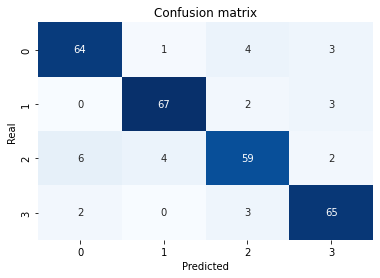


- SHAP values


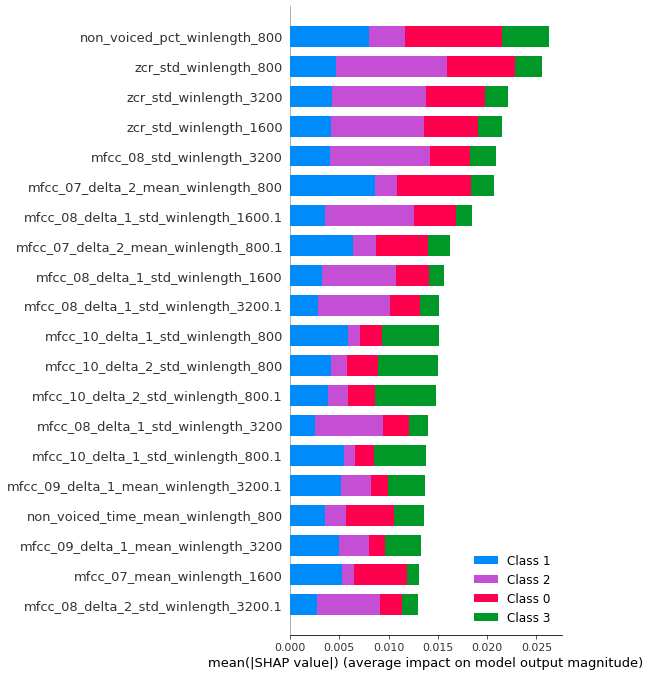

CPU times: user 12.1 s, sys: 720 ms, total: 12.8 s
Wall time: 13.9 s


In [80]:
%%time
model_rf = RandomForestClassifier(criterion='gini', n_jobs=-1, random_state=42, class_weight="balanced")
model_name = 'rf'
pipe_rf = Pipeline([(model_name, model_rf)])
params_rf = {
    "rf__n_estimators": [100, 250, 500, 1000],
    "rf__max_depth": [5, 10, 15],
    "rf__min_samples_split": [3, 5, 7],
    "rf__min_samples_leaf": [3, 5, 7]
}
model_rf_best = train_and_evaluate_model(pipe_rf, params_rf, X_train, y_train, X_test, y_test, model_name=model_name)

##### 3.2.2 SVM

============== Model: svc ==============
- Model training
Training the model svc...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Model svc trained!
# Model search results:
{'mean_fit_time': array([0.37622142, 0.34774232, 0.34037576, 0.3311018 , 0.35194483,
       0.30192499]), 'std_fit_time': array([0.01604609, 0.0059451 , 0.01355108, 0.01264034, 0.01813578,
       0.01812616]), 'mean_score_time': array([0.01951513, 0.01796031, 0.01748891, 0.01681304, 0.01586342,
       0.01469884]), 'std_score_time': array([0.00133864, 0.0002779 , 0.00239592, 0.00132687, 0.00203666,
       0.00179541]), 'param_svc__C': masked_array(data=[0.01, 0.1, 1, 5, 10, 25],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'svc__C': 0.01}, {'svc__C': 0.1}, {'svc__C': 1}, {'svc__C': 5}, {'svc__C': 10}, {'svc__C': 25}], 'split0_test_score': array([0.92730392, 0.93637998, 0.93637998, 0.93637998, 0.93637998,
       0.93637998]),

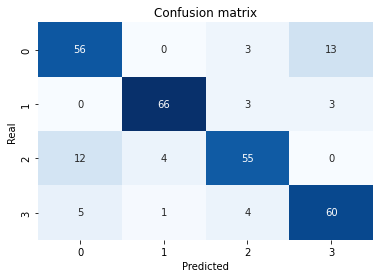


- Feature importance


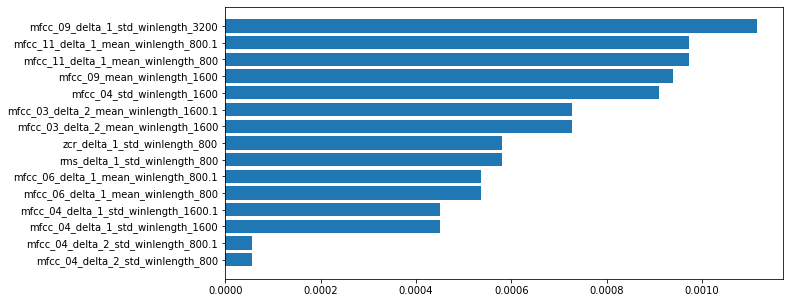

CPU times: user 962 ms, sys: 674 ms, total: 1.64 s
Wall time: 2.52 s


In [93]:
%%time
model_svc = SVC(kernel="linear", probability=True, class_weight='balanced', random_state=42)
model_name = "svc"
pipe_svc = Pipeline([('scaler', StandardScaler()), (model_name, model_svc)])
params_svc = {
    "svc__C": [0.01, 0.1, 1, 5, 10, 25],
}
model_svc_best = train_and_evaluate_model(pipe_svc, params_svc, X_train, y_train, X_test, y_test, model_name=model_name)

##### 3.2.3 Naive Bayes

============== Model: nb ==============
- Model training
Training the model nb...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model nb trained!
# Model search results:
{'mean_fit_time': array([0.01266608, 0.0151432 , 0.00705795, 0.00572753, 0.00433273,
       0.00584812, 0.00409613, 0.00587301, 0.00526924, 0.00443358,
       0.00327663, 0.00591111, 0.00753064, 0.00582452, 0.0055934 ,
       0.00337515, 0.00623245, 0.00401244, 0.00469904, 0.0042706 ,
       0.00565758, 0.00505495, 0.00373683, 0.0037118 , 0.00658884,
       0.00521426, 0.00430255, 0.00375113, 0.00565338, 0.0038938 ,
       0.00615873, 0.00423427, 0.00547395, 0.00537672, 0.00430002,
       0.00763602, 0.00392299, 0.00730057, 0.00611458, 0.00369554,
       0.00600176, 0.00583844, 0.00458198, 0.00569749, 0.00589142,
       0.00567689, 0.0069767 , 0.00475321, 0.007265  , 0.00415816,
       0.00444117, 0.00518041, 0.00453482, 0.0058393 , 0.003971  ,
       0.00522385, 0.00464735, 0.00645976, 0.0041081 , 0.0

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


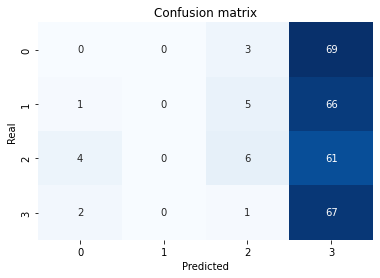


- Feature importance
CPU times: user 364 ms, sys: 38 ms, total: 402 ms
Wall time: 1.72 s


In [98]:
%%time
model_nb = GaussianNB()
model_name = "nb"
pipe_nb = Pipeline([(model_name, model_nb)])
params_nb = {
    "nb__var_smoothing": np.logspace(0, -9, num=100)
}
model_nb_best = train_and_evaluate_model(pipe_nb, params_nb, X_train, y_train, X_test, y_test, model_name=model_name)

##### 3.2.4 Regressão Logística

============== Model: lr ==============
- Model training
Training the model lr...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Model lr trained!
# Model search results:
{'mean_fit_time': array([2.08797455e-02, 1.41278553e-01, 3.68083000e-02, 3.02557755e-01,
       1.84456833e+01, 1.15402355e+00, 1.98172725e+01, 3.34194913e+00,
       2.49775674e+01, 4.28723326e+00, 2.25721007e+01, 5.19526486e+00]), 'std_fit_time': array([0.00785783, 0.01361061, 0.00840731, 0.03295339, 3.01418357,
       0.10581686, 4.55932205, 0.4424907 , 6.83582291, 0.52074958,
       2.6385111 , 0.28966534]), 'mean_score_time': array([0.00344305, 0.00600128, 0.00448627, 0.00512977, 0.00514479,
       0.0051785 , 0.00436273, 0.00717697, 0.00524492, 0.00373187,
       0.00403214, 0.00497541]), 'std_score_time': array([0.00045504, 0.00221454, 0.00172544, 0.00220595, 0.00239352,
       0.00211964, 0.00201339, 0.00373884, 0.0019482 , 0.00060263,
       0.00131506, 0.00222549]), 'param_lr__C': masked_array(

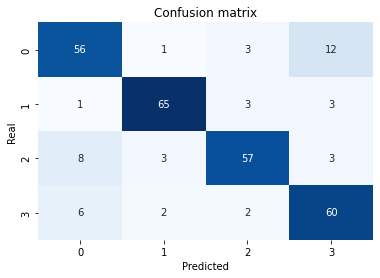


- Feature importance


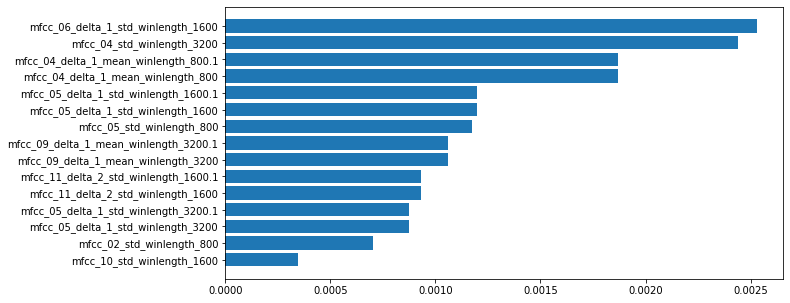

CPU times: user 2.13 s, sys: 521 ms, total: 2.65 s
Wall time: 1min 7s


In [97]:
%%time
model_lr = LogisticRegression(class_weight="balanced", fit_intercept=True, max_iter=10000, random_state=42, solver="saga")
model_name = "lr"
pipe_lr = Pipeline([('scaler', StandardScaler()), (model_name, model_lr)])
params_lr = {
    "lr__penalty": ["l1", "l2"],
    "lr__C": [0.001, 0.01, 0.1, 1.0, 2.0, 3.0]
}
model_lr_best = train_and_evaluate_model(pipe_lr, params_lr, X_train, y_train, X_test, y_test, model_name=model_name)

* **Modelos neurais**

Para os modelos neurais, vou implementar as redes usando as classes do PyTorch.

In [202]:
import torch
import torch.nn as nn

In [203]:
torch.manual_seed(0)

In [204]:
X_train_tensor = torch.tensor(X_train.values)
X_test_tensor = torch.tensor(X_test.values)

In [205]:
X_train_tensor.shape

torch.Size([662, 460])

In [206]:
df_languages = pd.DataFrame(data=sorted(y_train.unique()), columns=["language"])
df_languages = df_languages.reset_index()
df_languages

index    language
0      0     italian
1      1      polish
2      2  portuguese
3      3     spanish

In [207]:
y_train_index = [df_languages[df_languages["language"] == language]["index"].item() for language in y_train]
y_test_index = [df_languages[df_languages["language"] == language]["index"].item() for language in y_test]

In [208]:
y_train_tensor = torch.tensor(y_train_index)
y_test_tensor = torch.tensor(y_test_index)

In [209]:
y_train_tensor = torch.nn.functional.one_hot(y_train_tensor, num_classes=4)
y_test_tensor = torch.nn.functional.one_hot(y_test_tensor, num_classes=4)

In [210]:
X_train_tensor = X_train_tensor.float()
X_test_tensor = X_test_tensor.float()
y_train_tensor = y_train_tensor.float()
y_test_tensor = y_test_tensor.float()

In [211]:
X_train_tensor.dtype, X_test_tensor.dtype, y_train_tensor.dtype, y_test_tensor.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

##### 3.2.5 Multilayer Perceptron

In [331]:
class MLP(torch.nn.Module):
    def __init__(self): # Inititalization method - initial values
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(460, 40)
        self.fc2 = torch.nn.Linear(40, 40)
        self.fc3 = torch.nn.Linear(40, 20)
        self.fc4 = torch.nn.Linear(20, 4)
        self.activation = torch.nn.ReLU() # usar ReLU
        self.activation_end = torch.nn.Sigmoid() # usar ReLU
        
    def forward(self, x):
        y = self.fc1(x)
        y = self.activation(y)
        y = self.fc2(y) # linear output
        y = self.activation(y) # linear output
        y = self.fc3(y) # linear output
        y = self.activation(y) # linear output
        y = self.fc4(y) # linear output
        y = self.activation_end(y) # linear output
        return y

In [332]:
net = MLP()

In [333]:
net.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0125,  0.0084, -0.0103,  ..., -0.0284, -0.0201,  0.0109],
                      [ 0.0241, -0.0459,  0.0164,  ..., -0.0465,  0.0054, -0.0443],
                      [ 0.0168,  0.0401, -0.0350,  ..., -0.0367, -0.0283, -0.0410],
                      ...,
                      [-0.0463, -0.0202,  0.0086,  ...,  0.0214,  0.0438, -0.0208],
                      [-0.0009, -0.0425,  0.0392,  ..., -0.0464, -0.0080, -0.0458],
                      [-0.0125,  0.0130,  0.0330,  ..., -0.0450,  0.0167,  0.0005]])),
             ('fc1.bias',
              tensor([-0.0108, -0.0096, -0.0302, -0.0089, -0.0430, -0.0338, -0.0008,  0.0071,
                       0.0381, -0.0314, -0.0326,  0.0382, -0.0219,  0.0431, -0.0027,  0.0402,
                      -0.0371,  0.0369,  0.0417, -0.0304, -0.0156, -0.0116,  0.0117, -0.0047,
                      -0.0228,  0.0065,  0.0021,  0.0442, -0.0448, -0.0147, -0.0378,  0.0151,
                       0.0190,  0.01

In [334]:
learning_rate = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss_func = torch.nn.MSELoss()

epochs = 10000
loss_data = np.zeros(epochs)

# train the network
for epoch in range(epochs):
    prediction = net(X_train_tensor) # input x and predict based on x
    loss = loss_func(prediction, y_train_tensor) # must be (1. nn output, 2. target)
    
    optimizer.zero_grad() # clear gradients for next train
    loss.backward() # backpropagation, compute gradients
    optimizer.step() # apply gradients
    
    if epoch % 50 == 0:
        print(f'epoch {epoch+1} loss = {loss.item():.8f}')

epoch 1 loss = 0.29945767
epoch 51 loss = 0.22928505
epoch 101 loss = 0.24367385
epoch 151 loss = 0.25103781
epoch 201 loss = 0.23486635
epoch 251 loss = 0.23346311
epoch 301 loss = 0.21301678
epoch 351 loss = 0.20902357
epoch 401 loss = 0.20879140
epoch 451 loss = 0.20928591
epoch 501 loss = 0.21826623
epoch 551 loss = 0.19899134
epoch 601 loss = 0.18878594
epoch 651 loss = 0.19638087
epoch 701 loss = 0.19099341
epoch 751 loss = 0.18981223
epoch 801 loss = 0.19447018
epoch 851 loss = 0.20552020
epoch 901 loss = 0.18917376
epoch 951 loss = 0.19408573
epoch 1001 loss = 0.19494170
epoch 1051 loss = 0.17753391
epoch 1101 loss = 0.17051607
epoch 1151 loss = 0.17208962
epoch 1201 loss = 0.17571971
epoch 1251 loss = 0.20345590
epoch 1301 loss = 0.19522150
epoch 1351 loss = 0.19621691
epoch 1401 loss = 0.18684624
epoch 1451 loss = 0.17744701
epoch 1501 loss = 0.16878319
epoch 1551 loss = 0.16372570
epoch 1601 loss = 0.18165994
epoch 1651 loss = 0.16791348
epoch 1701 loss = 0.16510887
epoch 17

In [338]:
X_train_tensor = X_train_tensor.detach()
y_train_tensor = y_train_tensor.detach()
X_test_tensor = X_test_tensor.detach()
y_test_tensor = y_test_tensor.detach()

In [1]:
df_languages

NameError: name 'df_languages' is not defined

In [364]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    print("- Hold-out validation:")
    probas_train = model(X_train)
    probas_test = model(X_test)
    
    argmax_pred_train = np.argmax(probas_train.detach().numpy(), axis=1)
    y_pred_train = [df_languages.loc[df_languages["index"] == class_nb]["language"].item() for class_nb in argmax_pred_train]
    y_train = y_train.detach().numpy()
    argmax_train = np.argmax(y_train, axis=1)
    y_train = [df_languages.loc[df_languages["index"] == class_nb]["language"].item() for class_nb in argmax_train]
    print("# Classification report (train):\n{}".format(classification_report(y_train, y_pred_train)))
    
    argmax_pred_test = np.argmax(probas_test.detach().numpy(), axis=1)
    y_pred_test = [df_languages.loc[df_languages["index"] == class_nb]["language"].item() for class_nb in argmax_pred_test]
    y_test = y_test.detach().numpy()
    argmax_test = np.argmax(y_test, axis=1)
    y_test = [df_languages.loc[df_languages["index"] == class_nb]["language"].item() for class_nb in argmax_test]
    print("# Classification report (test):\n{}".format(classification_report(y_test, y_pred_test)))
    print()

    #print("- ROC Curve")
    #RocCurveDisplay.from_estimator(model, X_test, y_test)
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.show()
    #print()
    
    print("- Confusion matrix")
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, cmap="Blues", annot=True, cbar=False, fmt='d')
    plt.title("Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()
    print()
    
    ## SHAP
    #print("- Feature importance")
    #print(X_train.shape, X_test.shape)
    #torch.set_grad_enabled(True)
    #explainer = shap.DeepExplainer(model, X_train)
    #shap_values = explainer.shap_values(X_test)
    #plt.figure(figsize=(10, 5))
    #shap.summary_plot(shap_values, X_test)
    #plt.show()

In [365]:
net

MLP(
  (fc1): Linear(in_features=460, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=4, bias=True)
  (activation): ReLU()
  (activation_end): Sigmoid()
)

torch.Size([662, 460]) torch.Size([285, 460])
- Hold-out validation:
# Classification report (train):
              precision    recall  f1-score   support

     italian       0.92      0.86      0.89       168
      polish       1.00      0.68      0.81       166
  portuguese       0.96      0.70      0.81       165
     spanish       0.60      0.99      0.75       163

    accuracy                           0.81       662
   macro avg       0.87      0.81      0.81       662
weighted avg       0.87      0.81      0.81       662

# Classification report (test):
              precision    recall  f1-score   support

     italian       0.77      0.76      0.77        72
      polish       0.92      0.64      0.75        72
  portuguese       0.92      0.68      0.78        71
     spanish       0.55      0.89      0.68        70

    accuracy                           0.74       285
   macro avg       0.79      0.74      0.75       285
weighted avg       0.79      0.74      0.75       2

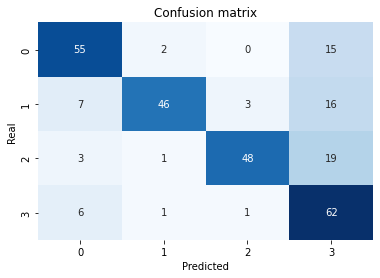

In [366]:
print(X_train_tensor.shape, X_test_tensor.shape)
evaluate_model(net, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)